In [1]:
import sys
import os
import time
import argparse
import numpy as np
import random
import pickle
import itertools
import copy
import pandas as pd
from scipy.special import comb
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
from tqdm.notebook import tqdm

sns.set_style("whitegrid") #darkgrid
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
SMALL_SIZE=12
MEDIUM_SIZE=15
BIGGER_SIZE=20
plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
#plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
#plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.layers as layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow.keras.metrics as metrics

physical_devices = tf.config.list_physical_devices('GPU')
try:
  tf.config.experimental.set_memory_growth(physical_devices[0], True)
except:
  # Invalid device or cannot modify virtual devices once initialized.
  pass

import concept_model
import helper
# from test_baselines import run_eval


from utils.test_utils import arg_parser, prepare_data, get_measures
from utils.test_utils import ConceptProfiles
from utils.test_utils import get_recovered_features
from utils.ood_utils import run_ood_over_batch
from utils.stat_utils import hellinger, compute_pval, bayes_posterior, FLD, multivar_separa
from utils.plot_utils import plot_stats, plot_per_class_stats, plot_score_distr
from utils import log


2024-08-12 10:59:45.980848: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-12 10:59:45.997429: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 10:59:46.016910: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 10:59:46.022765: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 10:59:46.036668: I tensorflow/core/platform/cpu_feature_guar

In [2]:
class ARGS:
    def __init__(self):

        self.in_data = "data/AwA2/test"
        self.out_data = "SUN" # MSCOCO
        self.workers = 4
        
        self.batch_size = 256
        self.name = "test"
        self.model = "InceptionV3"
        self.model_path = "results/AwA2/inceptionv3_AwA2_normal_epoch_40.weights.h5"
        self.concept_sim_thr = 0.95
        
        self.gpu = "0"
        self.result_dir = f"results/AwA2_2_baseline_normal/epoch_40_{self.concept_sim_thr}" # "results/AwA2_2_feat_l2_0.1_ood_1_sep_50_s0_thr_0.2/epoch_40"
        self.logdir = self.result_dir+"/logs"
        
        self.visualize = True # True False
        self.visualize_with_ood = True # True False
        self.shap = True
        self.separate = True
        self.explain = True
        self.plot = True
        self.out_data_dim = 224
        self.score = "energy"
        self.temperature_energy = 1
        self.temperature_odin = 1000
        

        self.opt = "adam"

args = ARGS()
softmax = layers.Activation('softmax')

In [3]:
def remove_duplicate_concepts(topic_vec, return_mapping=False, thr=0.95):
    # Remove one concept vector if there are two vectors where the dot product is over 0.95
    # topic_vec: dim=(dim_features, n_concepts) (2048, 70)
    # print(np.shape(topic_vec))
    n_concept = topic_vec.shape[1]
    topic_vec_n = topic_vec/(np.linalg.norm(topic_vec,axis=0,keepdims=True)+1e-9)

    topic_vec_n_dot = np.transpose(topic_vec_n) @ topic_vec_n - np.eye(n_concept)
    dict_similar_topic = {}
    idx_delete = set()
    for i in range(n_concept):
        ith_redundant_concepts = [j for j in range(n_concept) if topic_vec_n_dot[i][j] >= thr]
        dict_similar_topic[i] = ith_redundant_concepts
        
        ith_redundant_concepts = [x for x in ith_redundant_concepts if x > i]
        idx_delete.update(ith_redundant_concepts)
    idx_delete = list(idx_delete)

    topic_vec_r = np.delete(topic_vec, idx_delete, axis=1)


    dict_topic_mapping = {}
    count = 0
    for i in range(n_concept):
        if i in idx_delete:
            dict_topic_mapping[i] = None
        else:
            dict_topic_mapping[i] = count
            count += 1
    print('concept mapping between before/after duplicate removal......')
    print(dict_topic_mapping)
    if return_mapping:
        return topic_vec_r, dict_similar_topic, dict_topic_mapping
    else:
        return topic_vec_r, dict_similar_topic

def visualize_nn(test_loader, topic_vec, f_test, save_dir, logger, out_data=None, dir="concepts"):
    num_concept = topic_vec.shape[1]

    f_test_n = f_test/(np.linalg.norm(f_test,axis=3,keepdims=True)+1e-9)
    topic_vec_n = topic_vec/(np.linalg.norm(topic_vec,axis=0,keepdims=True)+1e-9)
    topic_prob = np.matmul(f_test_n,topic_vec_n)
    n_size = np.shape(f_test)[1]
    for i in range(num_concept):
      savepath = os.path.join(save_dir, dir, 'concept'+str(i))
      os.makedirs(savepath, exist_ok=True)
        
      neighbors_num = 15
      ind = np.argpartition(topic_prob[:,:,:,i].flatten(), -neighbors_num)[-neighbors_num:]
      sim_list = topic_prob[:,:,:,i].flatten()[ind]
      logger.info(f'[ID TEST: CONCEPT {i}] top-{neighbors_num} scores: {sim_list}')
      for jc,j in enumerate(ind):
        j_int = int(np.floor(j/(n_size*n_size)))
        a = int((j-j_int*(n_size*n_size))/n_size)
        b = int((j-j_int*(n_size*n_size))%n_size)
        
        if not out_data:
            f1 = savepath+'/concept_full_{}_{}_sim_{}.png'.format(i,jc, round(sim_list[jc], 3))
            f2 = savepath+'/concept_{}_{}_sim_{}.png'.format(i,jc, round(sim_list[jc], 3)) 
        else:
            f1 = savepath+'/{}_concept_full_{}_{}_sim_{}.png'.format(out_data, i,jc, round(sim_list[jc], 3))
            f2 = savepath+'/{}_concept_{}_{}_sim_{}.png'.format(out_data, i,jc, round(sim_list[jc], 3))
            
        # if sim_list[jc]>0.70:
        x_test_filename = test_loader.filepaths[j_int]
        helper.copy_save_image(x_test_filename,f1,f2,a,b)
        

def compute_concept_scores(topic_vec, feature, predict_model=None):
    # topic_vec: concept vectors (dim= (feature_dim, n_concepts))
    # feature: features extracted from an intermediate layer of trained model

    feature_n = tf.math.l2_normalize(feature, axis=3)
    topic_vec_n = tf.math.l2_normalize(topic_vec, axis=0)

    topic_prob = tf.matmul(feature_n, topic_vec_n) # K.dot

    prob_max = tf.math.reduce_max(topic_prob, axis=(1,2))
    prob_max_abs = tf.math.reduce_max(tf.abs(topic_prob), axis=(1,2))
    concept_scores = tf.where(prob_max == prob_max_abs, prob_max, -prob_max_abs)

    """
    ##for debugging
    n_concept = np.shape(concept_scores)[1]
    print(tf.reduce_mean(input_tensor=tf.nn.top_k(K.transpose(K.reshape(topic_prob,(-1,n_concept))),k=10,sorted=True).values))
    print(tf.reduce_mean(input_tensor=K.dot(K.transpose(K.variable(value=topic_vec_n)), K.variable(value=topic_vec_n)) - np.eye(n_concept)))
    """


    if predict_model: # in eager execution
        pred = softmax(predict_model(feature))
        #pred = tf.math.argmax(pred, axis=1)
        return concept_scores.numpy(), pred.numpy()
    else:
        return concept_scores

def prepare_profiles(feature_model, topic_vec, num_classes, args, logger):
    # profiling using validation data
    #profile_path = "{}/AwA2_train_concept_dict.pkl".format(args.result_dir)
    profile_path = "{}/AwA2_val_concept_dict.pkl".format(args.result_dir)
    if not os.path.exists(profile_path):
        logger.info("Profiling the distribution of concept scores from train set...")

        tf.random.set_seed(0)
        datagen = ImageDataGenerator(rescale=1./255.)
                                                #rotation_range=40,
                                                #width_shift_range=0.2, height_shift_range=0.2,
                                                #shear_range=0.2, zoom_range=0.2,
                                                #horizontal_flip=True)
        data_loader = datagen.flow_from_directory("data/AwA2/val", \
                                                batch_size=350, target_size=(224,224), \
                                                class_mode='categorical', \
                                                shuffle=False)

        ConceptP = ConceptProfiles()
        ConceptP.setUp(num_classes, data_loader)
        ConceptP.prepare_concept_dict(feature_model, topic_vec)
        concept_dict = ConceptP.concept_dict

        #LOAD_DIR = 'data/Animals_with_Attributes2'
        #y_train = np.load(LOAD_DIR+'/y_train.npy')
        #y_train = np.argmax(y_train, axis=1)

        logger.info("Saving concept profiles of AwA2 train set in {}".format(profile_path))
        with open(profile_path,'wb') as f:
            pickle.dump(concept_dict, f)

    else:
        logger.info("Loading concept profiles of AwA2 train set from {}".format(profile_path))
        with open(profile_path,'rb') as f:
            concept_dict = pickle.load(f)

    return concept_dict


def compute_coherency(feature, topic_vec):
    """
    compute coherency across top-k nearest neighbors for each concept
    :param topic_vec: concept vectors, dim=(feature_dim, num_concept)
    :param feature: features extracted from an intermediate layer of trained model
    """

    # normalize
    feature_n = tf.math.l2_normalize(feature, axis=3)
    topic_vec_n = tf.math.l2_normalize(topic_vec, axis=0)
    
    topic_prob = tf.matmul(feature_n, topic_vec_n) # normalized concept scores, dim=(num_data, num_concept)
    num_concept = topic_prob.shape[1]
    coher = tf.reduce_mean(tf.nn.top_k(K.transpose(K.reshape(topic_prob,(-1,num_concept))),k=10,sorted=True).values)
    return coher.numpy()

def compute_redundancy(topic_vec):
    """
    compute similarity between concept vectors
    :param topic_vec: normalized concept vectors, dim=(dim_feat, num_concept)
    """
    num_concept = topic_vec.shape[-1]

    topic_vec_n = tf.math.l2_normalize(topic_vec, axis=0)
    redun = tf.reduce_mean(K.dot(K.transpose(topic_vec_n), topic_vec_n) - np.eye(num_concept))
    return redun.numpy()

def compute_completeness(y, yhat, yhat_recov, num_class, logger=None, label=None):
    """
    compute completeness score by Yeh et al.
    :param y: groundtruth class labels, dim=(N,)
    :param yhat: predicted class labels, dim=(N,)
    :param yhat_recov: predicted class labels using recovered features, dim=(N,).
                       If label is not None, per-class predicted labels, dim=(N',) where N' <= N
    """

    acc = np.sum(y == yhat)/len(y)
    if logger:
        logger.info(f'[ID TEST] accuracy with original features: {acc}')
    
    if label is not None:
        acc_recov = np.sum(y[y==label] == yhat_recov)/len(yhat_recov)
        if logger:
            logger.info(f'[ID TEST] per-class accuracy with recovered features: {acc_recov}')
        acc_random = 1/num_class #0.5 #NOTE: check a_r = 0.5?
    else:
        acc_recov = np.sum(y == yhat_recov)/len(y)
        if logger:
            logger.info(f'[ID TEST] accuracy with recovered features: {acc_recov}')
        acc_random = 1/num_class
    
    # compute completeness
    completeness = (acc_recov - acc_random) / (acc - 1/num_class)
    if logger:
        logger.info(f'[ID TEST] completeness score: {completeness}')
    return completeness

def compute_detection_completeness(auroc, auroc_recov, logger=None):
    """
    compute detection completeness score
    """
    # compute completeness
    auroc_random = 1/2
    completeness = (auroc_recov - auroc_random) / (auroc - auroc_random)
    if logger:
        logger.info(f'[DETECTION] auroc with original features: {auroc}')
        logger.info(f'[DETECTION] auroc with recovered features: {auroc_recov}')
        logger.info(f'[DETECTION] completeness score: {completeness}')
    return completeness


def compute_conceptSHAP(concept_mask, topic_vec, 
                        feat_in, feat_out, y, yhat_in, yhat_out, auroc,
                        in_loader, out_loader,
                        topic_model, feature_model, args, logger, 
                        finetune=False, labels=None):

    assert labels is not None

    num_class = 50
    num_concept = topic_vec.shape[1]

    ## modify topic model
    logger.info(f'[ConceptSHAP] using concept mask: {concept_mask}.....')
    #topic_vec_temp = np.random.rand(topic_vec.shape[0], topic_vec.shape[1]) 
    topic_vec_temp = copy.copy(topic_vec)
    topic_vec_temp[:,np.array(concept_mask)==0] = 0
    #print(topic_model.layers[0].get_weights())
    topic_model.layers[0].set_weights([topic_vec_temp])
    #print(topic_model.layers[0].get_weights())

    _, logits_in, _ = topic_model(feat_in)
    _, logits_out, _ = topic_model(feat_out)


    compl_class, compl_detect = np.array([]), np.array([])
    compl_class_2, compl_detect_2 = np.array([]), np.array([])
    for label in labels:
        # compute classification completeness
        _, logits, _ = topic_model(feat_in[np.where(y == label)[0]])
        #print(logits)
        yhat_in_recov = tf.math.argmax(logits, axis=1)
        _compl_class = compute_completeness(y, yhat_in, yhat_in_recov, num_class, logger, label)
        compl_class = np.append(compl_class, _compl_class) 
        
        # compute detection completeness
        idx_in = np.where(tf.math.argmax(logits_in, axis=1).numpy() == label)[0]
        idx_out = np.where(tf.math.argmax(logits_out, axis=1).numpy() == label)[0]
        logger.info(f'[ConceptSHAP CLASS {label}] number of ID: {len(idx_in)} | number of OOD: {len(idx_out)}')
        if len(idx_in) == 0 or len(idx_out) == 0:
            compl_detect = np.append(compl_detect, None)
            continue

        s_in = run_ood_over_batch(None, feature_model, topic_model, args, num_class, feat_in[idx_in])
        s_out = run_ood_over_batch(None, feature_model, topic_model, args, num_class, feat_out[idx_out])
        #s_in, s_out = np.random.rand(len(idx_in)), np.random.rand(len(idx_out))
        auroc_recov, aupr_in, aupr_out, fpr95, thres95 = get_measures(s_in[:,None],s_out[:,None])
        _compl_detect = compute_detection_completeness(auroc, auroc_recov, logger)
        compl_detect = np.append(compl_detect, _compl_detect) 
        logger.info(f'[ConceptSHAP CLASS {label}] auroc: {auroc_recov} | aupr_in: {aupr_in} | aupr_out: {aupr_out} | fpr95: {fpr95} | thres95: {thres95}')
        logger.info(f'[ConceptSHAP CLASS {label}] (before finetuning) classification completeness: {_compl_class} | detection completeness: {_compl_detect}')

        if finetune:
            target_size = (224, 224)
            batch_size = args.batch_size
            train_datagen = ImageDataGenerator(rescale=1. / 255.,
                                           rotation_range=40,
                                           width_shift_range=0.2,
                                           height_shift_range=0.2,
                                           shear_range=0.2,
                                           zoom_range=0.2,
                                           horizontal_flip=True)
            train_loader = train_datagen.flow_from_directory('data/AwA2/train',
                                                    batch_size=batch_size,
                                                    target_size=target_size,
                                                    class_mode='categorical',
                                                    shuffle=True)
            # datagen = ImageDataGenerator(rescale=1.0 / 255.)
            # ood_loader = datagen.flow_from_directory("./data/MSCOCO",
            #                                     batch_size=batch_size,
            #                                     target_size=target_size,
            #                                     class_mode=None, shuffle=True)
    
            optimizer = Adam(learning_rate=0.01)
            optimizer_state = [optimizer.iterations, optimizer.learning_rate, optimizer.beta_1, optimizer.beta_2, optimizer.weight_decay]
            optimizer_reset = tf.compat.v1.variables_initializer(optimizer_state)
            softmax = layers.Activation('softmax')
            #train_acc_metric = tf.keras.metrics.CategoricalAccuracy()
            #test_acc_metric = tf.keras.metrics.CategoricalAccuracy()
        
            COEFF_CONCEPT = 10.0
        
            train_step_signature = [
            tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32),
            tf.TensorSpec(shape=(None, None), dtype=tf.float32),
            #tf.TensorSpec(shape=(None, None, None, 3), dtype=tf.float32), 
            ]
            @tf.function(input_signature=train_step_signature)
            def train_step(x_in, y_in): #, x_out=None):
                f_in = feature_model(x_in)
                f_in_n = K.l2_normalize(f_in,axis=(3))
            
                #f_out = feature_model(x_out)
                #f_out_n = K.l2_normalize(f_out,axis=(3))

                obj_terms = {} # terms in the objective function
                with tf.GradientTape() as tape:
                    f_in_recov, logits_in, topic_vec_n = topic_model(f_in, training=True)
                    pred_in = softmax(logits_in) # class prediction using concept scores
                    topic_prob_in_n = K.dot(f_in_n, topic_vec_n) # normalized concept scores

                    #_, logits_out, _ = topic_model(f_out, training=True)
                    #topic_prob_out_n = K.dot(f_out_n, topic_vec_n)

                    # baseline
                    CE_IN = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(y_in, pred_in))
                    loss_coherency = tf.reduce_mean(tf.nn.top_k(K.transpose(K.reshape(topic_prob_in_n,(-1,num_concept))),k=10,sorted=True).values)
                    loss_similarity = tf.reduce_mean(K.dot(K.transpose(topic_vec_n), topic_vec_n) - tf.eye(num_concept))
                    loss = CE_IN - COEFF_CONCEPT*loss_coherency + COEFF_CONCEPT*loss_similarity
                    obj_terms['[ID] CE'] = CE_IN
                    obj_terms['[ID] concept coherency'] = loss_coherency
                    obj_terms['[ID] concept similarity'] = loss_similarity

                grads = tape.gradient(loss, topic_model.trainable_variables)
                optimizer.apply_gradients(zip(grads, topic_model.trainable_variables))
                return obj_terms

            for layer in topic_model.layers:
                layer.trainable = True
                
            for step, (x_in, y_in) in enumerate(train_loader):
                step += 1
                if step == len(train_loader): # >100
                    break
                #x_out = ood_loader.__next__()
                obj_terms = train_step(x_in, y_in) #, x_out)
                if step % 20 == 0:
                    for term in obj_terms:
                        print(f'[STEP{step}] {term}: {obj_terms[term]}')

            for layer in topic_model.layers:
                layer.trainable = False
            #train_acc = train_acc_metric.result()
            #logger.info("Training acc over epoch: %.4f" % (float(train_acc),))

            # compute classification completeness
            _, logits, _ = topic_model(feat_in[np.where(y == label)[0]])
            #print(logits)
            yhat_in_recov = tf.math.argmax(logits, axis=1)
            _compl_class = compute_completeness(y, yhat_in, yhat_in_recov, num_class, logger, label)
            compl_class_2 = np.append(compl_class_2, _compl_class)

            # compute detection completeness
            idx_in = np.where(tf.math.argmax(logits_in, axis=1).numpy() == label)[0]
            idx_out = np.where(tf.math.argmax(logits_out, axis=1).numpy() == label)[0]
            s_in = run_ood_over_batch(None, feature_model, topic_model, args, num_class, feat_in[idx_in])
            s_out = run_ood_over_batch(None, feature_model, topic_model, args, num_class, feat_out[idx_out])
            auroc_recov, aupr_in, aupr_out, fpr95, thres95 = get_measures(s_in[:,None],s_out[:,None])
            _compl_detect = compute_detection_completeness(auroc, auroc_recov, logger)
            compl_detect_2 = np.append(compl_detect_2, _compl_detect)
            logger.info(f'[ConceptSHAP CLASS {label}] auroc: {auroc_recov} | aupr_in: {aupr_in} | aupr_out: {aupr_out} | fpr95: {fpr95} | thres95: {thres95}')
            logger.info(f'[ConceptSHAP CLASS {label}] (after finetuning) classification completeness: {_compl_class} | detection completeness: {_compl_detect}')

        logger.info('--------------------------------------------------------')

    topic_model.layers[0].set_weights([topic_vec])
    if finetune:
        return compl_class_2, compl_detect_2
    else:
        assert len(compl_class) == len(labels)
        assert len(compl_detect) == len(labels)
        return compl_class, compl_detect


def compute_separability(in_concept, out_concept, in_yhat, out_yhat, num_classes, logger=None):
    # compute Multivariate Separability (global)
    separa = {'global': multivar_separa(in_concept, out_concept).numpy()}

    # compute per-class separability
    # num_classes = 50
    num_concepts = in_concept.shape[1]
    for i in range(num_classes):
        idx_in = np.where(in_yhat == i)[0]
        idx_out = np.where(out_yhat == i)[0]
        if logger:
            logger.info(f'class {i}: num IN - {len(idx_in)}, num OUT - {len(idx_out)}')

        ## explanation using groundtruth ID/OOD labels
        #sep_concept_ith = FLD(in_concept[idx_in,:], out_concept[idx_out,:], optimal=False)
        sep_concept_ith = multivar_separa(in_concept[idx_in,:], out_concept[idx_out,:]).numpy()
        if logger:
            logger.info(f'[CLASS {i}: SEPARABILITY, CONCEPTS] separability using groundtruth ID/OOD: {sep_concept_ith}')

        separa['class'+str(i)] = sep_concept_ith

    return separa


def explain_topK(scores, top_k, separa, figname=None):
    """
    Plot bar graph of top-k largest average concept scores
    :param scores: concept scores, dim=(N,num_concepts)
    :param top_k: interested in printing top-k highest concept scores
    :param separa: separability score averaged across concepts or per-class multivariate separability
    """
    s_mean = np.mean(scores, axis=0)
    concept_idx = np.argsort(np.abs(s_mean))[::-1][:top_k] 
    
    num_types = 1 
    num_concepts = top_k
    bar_width = 0.35
    index = np.arange(num_concepts) * bar_width * (num_types + 1)

    fig, ax = plt.subplots(figsize=(3*top_k/5,3))
    bar = ax.bar(index + 0 * bar_width, s_mean[concept_idx],
            bar_width, yerr=np.std(scores[:,concept_idx],axis=0))
    ax.set_title('Top-{0} concept scores, separability: {1:.5f}'.format(top_k, separa))
    ax.set_ylabel('Concept score')
    ax.set_xticks(index + num_types * bar_width / 2)
    ax.set_xticklabels(['concept {}'.format(c) for c in concept_idx], rotation=45)
    fig.tight_layout()
    plt.savefig(figname)
    plt.close()


def explain_relative(scores, labels, separa, shap_class_i, figname, figname_dist, top_k=6):
    """
    scores: dictionary of concept scores of groundtruth ID, groundtruth OOD, ID -> ID, ID -> OOD, OOD -> ID, OOD -> OOD
    labels: labels for different types of scores
    separa: separability scores, dim=(num_concepts,)
    """
    # concepts with top-k separability scores
    concept_idx = np.argsort(shap_class_i)[::-1][:top_k] # top K: from largest to smallest value
    # concept_idx = np.arange(top_k)
    num_types = len(labels)
    num_concepts = top_k
    bar_width = 0.35
    # create location for each bar. scale by an appropriate factor to ensure 
    # the final plot doesn't have any parts overlapping
    index = np.arange(num_concepts) * bar_width * (num_types + 1)

    fig, ax = plt.subplots(figsize=(3*top_k/2,5))
    for i in range(num_types):
        bar = ax.bar(index + i * bar_width, np.mean(scores[labels[i]][:,concept_idx],axis=0),
                bar_width, yerr=np.std(scores[labels[i]][:,concept_idx],axis=0), 
                label=f"{labels[i]}, num={len(scores[labels[i]])}")
    ax.set_title('Concept scores for each concept and ID/OOD data, separability: {1:.5f}'.format(top_k, separa))
    ax.set_ylabel('Concept score')
    ax.set_xticks(index + num_types * bar_width / 2)
    ax.set_xticklabels([f'concept {c}\nshap={round(shap_class_i[c], 3)}' for c in concept_idx], rotation=45)
    ax.legend()
    fig.tight_layout()
    plt.savefig(figname)
    plt.close()



def save_images(filepaths, figname, k=5):

    fig, axes = plt.subplots(1,k)
    count = 0
    np.random.shuffle(filepaths)
    for f in filepaths:
        img = Image.open(f).resize((100,100), Image.LANCZOS)
        axes[count].imshow(img)
        #ax2.set_title("ID image", size=10, color='b')
        axes[count].axis('off')
    
        count += 1
        if count >= k:
            break

    fig.savefig(figname)
    plt.close()

def run_eval(feature_model, predict_model, in_loader, out_loader, logger, args, num_classes):
    in_scores = np.array([])
    for i, (x, y) in tqdm(enumerate(in_loader)):
        if i == len(in_loader):
            break
        score = run_ood_over_batch(x, feature_model, predict_model, args, num_classes).numpy()
        in_scores = np.concatenate([in_scores, score])
    out_scores = np.array([])
    for i, x in tqdm(enumerate(out_loader)):
        if i == len(in_loader):
            break
        score = run_ood_over_batch(x, feature_model, predict_model, args, num_classes).numpy()
        out_scores = np.concatenate([out_scores, score])
    in_examples = np.expand_dims(in_scores, axis=1)
    out_examples = np.expand_dims(out_scores, axis=1)
    auroc, aupr_in, aupr_out, fpr, thres95 = get_measures(in_examples, out_examples)
    return in_scores, out_scores, auroc, fpr, thres95

def get_class_labels(loader, savepath):
    """
    extract groundtruth class labels from data loader
    :param loader: data loader
    :param savepath: path to the numpy file
    """

    if os.path.exists(savepath):
        y = np.load(savepath)
    else:
        num_data = len(loader.filenames)
        y = []
        for (_, y_batch), _ in zip(loader, range(len(loader))):
            y.extend(y_batch)
       
        np.save(savepath, y)
    return y

In [4]:
with tf.device('/CPU:0'):

    logger = log.setup_logger(args, filename="eval_{}.log".format(args.score))
    LOAD_DIR = 'data/AwA2'
    TOPIC_PATH = os.path.join(args.result_dir,'topic_vec_inceptionv3.npy')
    INPUT_SHAPE = (args.out_data_dim, args.out_data_dim)
    TRAIN_DIR = "data/AwA2/train"
    N_CLASSES = 50
    N_CONCEPTS_ORIG = 100 #np.shape(topic_vec_orig)[-1]
    _ = 0
    
    if args.score == 'ODIN':
        args.batch_size = 200
    
    if not os.path.exists(os.path.join(args.result_dir, 'plots')):
        os.makedirs(os.path.join(args.result_dir, 'plots'))
    if not os.path.exists(os.path.join(args.result_dir, 'explanations')):
        os.makedirs(os.path.join(args.result_dir, 'explanations'))
    if not os.path.exists(os.path.join(args.result_dir, 'explanations', args.out_data+'_'+args.score)):
        os.makedirs(os.path.join(args.result_dir, 'explanations', args.out_data+'_'+args.score))
    explain_dir = os.path.join(args.result_dir, 'explanations', args.out_data+'_'+args.score)
    
    in_loader, out_loader = prepare_data(args, logger)
    
    ## load trained_model
    logger.info(f"Loading model from {args.model_path}")
    feature_model, predict_model = helper.load_model_inception_new(_, in_loader, batch_size=args.batch_size, 
                                        input_size=INPUT_SHAPE, pretrain=True, modelname=args.model_path)
    
    in_test_features = feature_model.predict(in_loader)
    out_test_features = feature_model.predict(out_loader, steps=len(in_loader))
    N_IN = in_test_features.shape[0]
    N_OUT = out_test_features.shape[0]


2024-08-12 10:59:51.198656: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 448 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:af:00.0, compute capability: 7.0
2024-08-12 10:59:51,208 [INFO] utils.log: <__main__.ARGS object at 0x7fd248492110>


Found 3772 images belonging to 50 classes.
Found 10000 images belonging to 1 classes.


2024-08-12 10:59:51,858 [INFO] utils.log: Using an in-distribution set.
2024-08-12 10:59:51,861 [INFO] utils.log: Using an out-of-distribution set.
2024-08-12 10:59:51,863 [INFO] utils.log: Loading model from results/AwA2/inceptionv3_AwA2_normal_epoch_40.weights.h5




original model to be trained


/home/dingw/.conda/envs/adv_train/lib/python3.11/site-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/home/dingw/.conda/envs/adv_train/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1723453212.869231 1339518 service.cc:146] XLA service 0x7fd0a00111c0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723453212.869310 1339518 service.cc:154]   StreamExecutor device (0): Host, Default Version
2024-08-12 11:00:12.995106: I tensor

15/15 ━━━━━━━━━━━━━━━━━━━━ 97s 6s/step - accuracy: 0.8741 - loss: 0.7714
Loss of the trained original model: 0.7113224267959595
Accuracy of the trained original model: 0.8950158953666687


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_2 (InputLayer)            │ (None, 5, 5, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling2d            │ (None, 2048)           │             0 │
│ (GlobalMaxPooling2D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 50)             │        12,850 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 537,394 (2.05 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 537,394 (2.05 MB)

None
15/15 ━━━━━━━━━━━━━━━━━━━━ 101s 6s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 104s 6s/step


In [5]:
args.result_dir

'results/AwA2_2_baseline_normal/epoch_40_0.95'

In [6]:
with tf.device('/CPU:0'):
    ## load topic model
    topic_model = concept_model.TopicModel(in_test_features, N_CONCEPTS_ORIG, thres=0.0, predict=predict_model)
    for layer in topic_model.layers:
        layer.trainable = False
    topic_model(in_test_features)
    topic_model.load_weights(os.path.dirname(args.result_dir)+f"/topic_epoch{os.path.dirname(args.logdir).split('_')[-2]}.weights.h5")

In [7]:
with tf.device('/CPU:0'):

    ## load topic_vec
    topic_vec_orig = topic_model.layers[0].get_weights()[0]
    np.save(args.result_dir+'/topic_vec_orig.npy', topic_vec_orig)
    logger.info(f'Number of concepts before removing duplicate ones: {str(N_CONCEPTS_ORIG)}')
    
    topic_vec, dict_dupl_topic = remove_duplicate_concepts(topic_vec_orig, thr=args.concept_sim_thr)
    N_CONCEPTS = np.shape(topic_vec)[-1] # 25
    logger.info(f'Number of concepts after removing duplicate ones: {str(N_CONCEPTS)}')
    
    in_test_concepts, in_test_logits = compute_concept_scores(topic_vec, in_test_features, predict_model)
    out_test_concepts, out_test_logits = compute_concept_scores(topic_vec, out_test_features, predict_model)
    in_test_yhat = np.argmax(in_test_logits, axis=1) 
    out_test_yhat = np.argmax(out_test_logits, axis=1)

2024-08-12 11:05:34,427 [INFO] utils.log: Number of concepts before removing duplicate ones: 100
2024-08-12 11:05:34,489 [INFO] utils.log: Number of concepts after removing duplicate ones: 34


concept mapping between before/after duplicate removal......
{0: 0, 1: 1, 2: 2, 3: 3, 4: None, 5: 4, 6: 5, 7: None, 8: 6, 9: 7, 10: 8, 11: 9, 12: 10, 13: None, 14: None, 15: 11, 16: None, 17: 12, 18: 13, 19: None, 20: None, 21: 14, 22: 15, 23: 16, 24: 17, 25: None, 26: 18, 27: 19, 28: None, 29: 20, 30: None, 31: None, 32: None, 33: 21, 34: 22, 35: None, 36: 23, 37: None, 38: None, 39: None, 40: 24, 41: None, 42: None, 43: None, 44: None, 45: None, 46: None, 47: None, 48: None, 49: None, 50: None, 51: 25, 52: None, 53: None, 54: None, 55: None, 56: None, 57: None, 58: None, 59: None, 60: None, 61: None, 62: None, 63: None, 64: None, 65: 26, 66: None, 67: None, 68: None, 69: None, 70: None, 71: 27, 72: None, 73: 28, 74: None, 75: None, 76: None, 77: 29, 78: 30, 79: None, 80: None, 81: None, 82: 31, 83: 32, 84: None, 85: None, 86: None, 87: None, 88: None, 89: None, 90: None, 91: None, 92: None, 93: None, 94: None, 95: None, 96: None, 97: None, 98: 33, 99: None}


In [8]:
with tf.device('/CPU:0'):
    # target OOD detector
    logger.info("[ID TEST] performance of target OOD detector with test set...")
    in_test_scores, out_test_scores, auroc, fpr, thres95 = run_eval(feature_model, predict_model, in_loader, out_loader, logger, args, N_CLASSES)
    # in_test_scores, out_test_scores, thres95, auroc = np.random.rand(N_IN), np.random.rand(N_OUT), 0.5419758558273315, 0.955332290562036
    
    # Plot ID vs OOD scores by the target detector
    savefig = os.path.join(args.result_dir, 'plots', '{}_AwA2_test_{}_test.jpg'.format(args.score, args.out_data))
    plot_stats(in_test_scores, out_test_scores, savename=savefig)
    
    ######################################
    ## Evaluating coherency......
    coherency = compute_coherency(in_test_features, topic_vec)
    logger.info(f'[ID TEST] coherency: {coherency}')
    
    ######################################
    ## Evaluating redundancy.......
    redundancy = compute_redundancy(topic_vec)
    logger.info(f'[CONCEPTS] redundancy: {redundancy}')
    
    #######################################
    ## Evaluating the difference between two worlds......
    y_test = np.argmax(np.load('data/AwA2/y_test.npy'), axis=1) # true labels
    
    logger.info("[ID TEST RECOVERED] performance of target OOD detector with test set...")
    in_test_scores_recov, out_test_scores_recov, auroc_recov, fpr_recov, thres95_recov = run_eval(feature_model, topic_model, in_loader, out_loader, logger, args, N_CLASSES)
    savefig = os.path.join(args.result_dir, 'plots', '{}_recov_AwA2_test_{}_test.jpg'.format(args.score, args.out_data))
    plot_stats(in_test_scores_recov, out_test_scores_recov, savename=savefig)
    
    # compute completeness scores
    _, logits_recov, _ = topic_model(in_test_features)
    in_test_yhat_recov = tf.math.argmax(logits_recov, axis=1).numpy()
    compute_completeness(y_test, in_test_yhat, in_test_yhat_recov, N_CLASSES, logger)
    compute_detection_completeness(auroc, auroc_recov, logger)
    
    ######################################
    ## Compute Hellinger distance between original vs reconstructed classifier outputs
    in_test_logits_recov = softmax(logits_recov).numpy()
    H = np.array([hellinger(in_test_logits[i,:], in_test_logits_recov[i,:]) for i in range(in_test_logits.shape[0])])
    fig = plt.figure()
    ax = plt.subplot(111)
    sns.histplot(H, color='blue')
    ax.legend(['in-distribution (test)'])
    fig.savefig(os.path.join(args.result_dir, 'plots', 'classification_hellinger.jpg'))
    plt.close()
    
    ######################################
    # Save results....
    results = {'in_yhat':in_test_yhat, 'out_yhat':out_test_yhat, 
            'in_yhat_recov':in_test_yhat_recov, 
            # 'out_yhat_recov':out_test_yhat_recov,
            'in_logits':in_test_logits, 'in_logits_recov':in_test_logits_recov,
            'in_concepts':in_test_concepts, 'out_concepts':out_test_concepts,
            'in_scores':in_test_scores, 'out_scores':out_test_scores,
            'thres':thres95,
            'in_scores_recov':in_test_scores_recov, 'out_scores_recov':out_test_scores_recov}
    
    result_path = os.path.join(args.result_dir,'results_{}_{}.pkl'.format(args.score,args.out_data))
    with open(result_path,'wb') as f:
        pickle.dump(results, f)

2024-08-12 11:05:36,768 [INFO] utils.log: [ID TEST] performance of target OOD detector with test set...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

3046


2024-08-12 11:10:31,221 [INFO] utils.log: [ID TEST] coherency: 0.8638136386871338
2024-08-12 11:10:31,226 [INFO] utils.log: [CONCEPTS] redundancy: 0.017867231741547585
2024-08-12 11:10:31,234 [INFO] utils.log: [ID TEST RECOVERED] performance of target OOD detector with test set...


0it [00:00, ?it/s]

0it [00:00, ?it/s]

3176


2024-08-12 11:16:08,028 [INFO] utils.log: [ID TEST] accuracy with original features: 0.8950159066808059
2024-08-12 11:16:08,031 [INFO] utils.log: [ID TEST] accuracy with recovered features: 0.8753976670201484
2024-08-12 11:16:08,032 [INFO] utils.log: [ID TEST] completeness score: 0.977579562256102
2024-08-12 11:16:08,034 [INFO] utils.log: [DETECTION] auroc with original features: 0.9862402378269706
2024-08-12 11:16:08,035 [INFO] utils.log: [DETECTION] auroc with recovered features: 0.9727966071270767
2024-08-12 11:16:08,037 [INFO] utils.log: [DETECTION] completeness score: 0.9723518753610889


<Figure size 1200x400 with 0 Axes>

<Figure size 1200x400 with 0 Axes>

In [9]:
with tf.device('/CPU:0'):
    ## Evaluating separability of concepts......
    #separa_path = os.path.join(args.result_dir, 'separability_AwA2_{}_raw.npy'.format(args.out_data))
    separa_path = os.path.join(args.result_dir, 'separability_{}_AwA2_{}_multiv.npy'.format(args.score, args.out_data))
    if args.separate:
        idx_IN_IN = in_test_scores >= thres95
        idx_IN_OUT = ~idx_IN_IN
        idx_OUT_IN = out_test_scores >= thres95
        idx_OUT_OUT = ~idx_OUT_IN
        # separa = compute_separability(in_test_concepts, out_test_concepts, in_test_yhat, out_test_yhat, logger) # using groundtruth ID/OOD labels
        in_detect_concepts = np.r_[in_test_concepts[idx_IN_IN], out_test_concepts[idx_OUT_IN]]
        out_detect_concepts = np.r_[in_test_concepts[idx_IN_OUT], out_test_concepts[idx_OUT_OUT]]
        in_detect_yhat = np.r_[in_test_yhat[idx_IN_IN], out_test_yhat[idx_OUT_IN]]
        out_detect_yhat = np.r_[in_test_yhat[idx_IN_OUT], out_test_yhat[idx_OUT_OUT]]
        separa = compute_separability(in_detect_concepts, out_detect_concepts, in_detect_yhat, out_detect_yhat, N_CLASSES, logger) # using detector's ID/OOD results in canonical world
    
        separa_global = separa['global']
        logger.info(f'[GLOBAL SEPARABILITY] multivariate separability: {separa_global}')
        separa_class = np.array([separa['class'+str(i)] for i in range(N_CLASSES)], dtype=np.float64)
        logger.info(f'[PER-CLASS SEPARABILIRY] averaged separability: {np.nanmean(separa_class)}')
    
        rlt_dir_ = []
        for p_ in args.result_dir.split("/"):        
            if "AwA2" in p_:
                rlt_dir_ += ["AwA2_2_baseline_normal"]
            elif "epoch" in p_:
                rlt_dir_ += [f"epoch_40_{args.concept_sim_thr}"]
            else:
                rlt_dir_ += [p_]
        baseline_folder = "/".join(rlt_dir_)
    
        separa0_path = os.path.join(baseline_folder, 'separability_{}_AwA2_{}_multiv.npy'.format(args.score, args.out_data))
        if os.path.exists(separa0_path):
            import statistics 
            separa0 = np.load(separa0_path, allow_pickle=True).item()
            rel_separa_list = []
            for i in range(N_CLASSES):
                if np.isnan(separa0['class'+str(i)]) or np.isnan(separa['class'+str(i)]):
                    continue
                else:
                    rel_ = (separa['class'+str(i)] - separa0['class'+str(i)]) / separa0['class'+str(i)]
                    rel_separa_list.append(rel_)
            rel_separa = statistics.median(rel_separa_list)
            logger.info(f'[RELATIVE SEPARABILITY] relative separability: {rel_separa}')
            separa['relative'] = rel_separa
    
        np.save(separa_path, separa)


2024-08-12 11:16:08,937 [INFO] utils.log: class 0: num IN - 101, num OUT - 4
2024-08-12 11:16:08,944 [INFO] utils.log: [CLASS 0: SEPARABILITY, CONCEPTS] separability using groundtruth ID/OOD: 0.734642744064331
2024-08-12 11:16:08,946 [INFO] utils.log: class 1: num IN - 27, num OUT - 316
2024-08-12 11:16:08,954 [INFO] utils.log: [CLASS 1: SEPARABILITY, CONCEPTS] separability using groundtruth ID/OOD: 0.036323465406894684
2024-08-12 11:16:08,956 [INFO] utils.log: class 2: num IN - 19, num OUT - 31
2024-08-12 11:16:08,962 [INFO] utils.log: [CLASS 2: SEPARABILITY, CONCEPTS] separability using groundtruth ID/OOD: 0.9298259615898132
2024-08-12 11:16:08,964 [INFO] utils.log: class 3: num IN - 0, num OUT - 0
2024-08-12 11:16:08,969 [INFO] utils.log: [CLASS 3: SEPARABILITY, CONCEPTS] separability using groundtruth ID/OOD: nan
2024-08-12 11:16:08,971 [INFO] utils.log: class 4: num IN - 63, num OUT - 29
2024-08-12 11:16:08,977 [INFO] utils.log: [CLASS 4: SEPARABILITY, CONCEPTS] separability using

In [10]:
with tf.device('/CPU:0'):
    # Generating explanations.....
    classes = np.argsort(separa_class)[::-1]
    #classes = np.append(classes[:5],[c for c in classes[-9:] if separa_class[c]]) # omitting classes with separability==0
    classes = np.delete(classes, np.where(np.isnan(separa_class[classes]))[0])
    
    if args.explain:
        logger.info(f'classes with highest and lowest separabilities...: {classes}')
        k = 10
        for i in range(N_CLASSES):
    
            idx_in = np.where(in_test_yhat == i)[0]
            idx_out = np.where(out_test_yhat == i)[0]
            in_concepts_ith = in_test_concepts[idx_in,:] # concept scores of ID data classified as class i
            out_concepts_ith = out_test_concepts[idx_out,:] # concept scores of OOD data classified as class i
            
            if len(idx_in) == 0 or len(idx_out) ==0:
                continue
    
            # indices for OOD detection results
            idx_IN_IN = in_test_scores[idx_in] >= thres95   # ID detected as ID
            idx_IN_OUT = ~idx_IN_IN                 # ID detected as OOD
            idx_OUT_OUT = out_test_scores[idx_out] < thres95 # OOD detected as OOD
            idx_OUT_IN = ~idx_OUT_OUT               # OOD detected as ID
    
            # print(np.sum(idx_IN_IN))
            # print(np.sum(idx_IN_OUT))
            # print(np.sum(idx_OUT_OUT))
            # print(np.sum(idx_OUT_IN))
            
            explain_topK(in_concepts_ith, top_k=k, separa=separa_class[i], 
                        figname=os.path.join(explain_dir,'class{}_AwA2_top{}.jpg'.format(i, k)))
            explain_topK(out_concepts_ith, top_k=k, separa=separa_class[i],
                        figname=os.path.join(explain_dir,'class{}_{}_top{}.jpg'.format(i, args.out_data, k)))
    
    
            # # most prominent concepts for ID/OOD images
            # explain_topK(np.r_[in_concepts_ith[idx_IN_IN], out_concepts_ith[idx_OUT_IN]], top_k=k, separa=separa_class[i],
            #             figname=os.path.join(explain_dir,'class{}_AwA2_top{}_detected_{}.jpg'.format(i, k, args.score)))
            # explain_topK(np.r_[in_concepts_ith[idx_IN_OUT], out_concepts_ith[idx_OUT_OUT]], top_k=k, separa=separa_class[i],
            #             figname=os.path.join(explain_dir,'class{}_{}_top{}_detected_{}.jpg'.format(i, args.out_data, k, args.score)))
            
            
            # visualize example ID/OOD images
            in_files_ith = np.array(in_loader.filepaths)[idx_in]
            out_files_ith = np.array(out_loader.filepaths)[idx_out]
            if np.sum(idx_IN_IN)!=0:
                save_images(in_files_ith[idx_IN_IN], figname=os.path.join(explain_dir,'class{}_{}_AwA2_IN.jpg'.format(i, args.score)))
            if np.sum(idx_IN_OUT)!=0:
                save_images(in_files_ith[idx_IN_OUT], figname=os.path.join(explain_dir,'class{}_{}_AwA2_OUT.jpg'.format(i, args.score)))
            if np.sum(idx_OUT_OUT)!=0:
                save_images(out_files_ith[idx_OUT_OUT], figname=os.path.join(explain_dir,'class{}_{}_{}_OUT.jpg'.format(i, args.score, args.out_data)))
            if np.sum(idx_OUT_IN)!=0:
                save_images(out_files_ith[idx_OUT_IN], figname=os.path.join(explain_dir,'class{}_{}_{}_IN.jpg'.format(i, args.score, args.out_data)))
    logger.flush()
    
    
    ###########################################
    ## Computing ConceptSHAP.............
            
    if args.shap:
    
        shap_path = os.path.join(explain_dir,'{}_SHAP.pkl'.format(args.score.lower()))
        if os.path.exists(shap_path):
            print(f"Loading shap values from file {shap_path}")
            with open(shap_path,'rb') as f:
                shap_expl = pickle.load(f)
    
        else:
            nc = N_CONCEPTS_ORIG # number of concepts before duplicate removal
            #inputs = list(itertools.product([0, 1], repeat=N_CONCEPTS_ORIG)) #NOTE: computationally very expensive
            inputs = np.ones((len(dict_dupl_topic),nc))
            for d in dict_dupl_topic:
                idx = [d] + dict_dupl_topic[d]
                inputs[d,idx] = 0
            inputs = np.unique([tuple(row) for row in inputs], axis=0)
            # inputs = inputs[:2]
    
            #classes = [1, 4]
            outputs_class = np.array([])
            outputs_detect = np.array([])
            kernel = np.array([])
            for concept_mask in inputs:
                logger.info('======================================================')
                compl_class, compl_detect = compute_conceptSHAP(concept_mask, topic_vec_orig,
                                            in_test_features, out_test_features, y_test, in_test_yhat, out_test_yhat, auroc,
                                            in_loader, out_loader,
                                            topic_model, feature_model, args, logger,
                                            finetune=False, labels=list(range(N_CLASSES)))
                outputs_class = np.append(outputs_class, compl_class)
                outputs_detect = np.append(outputs_detect, compl_detect)
                k = np.sum(concept_mask)
                kernel = np.append(kernel, (nc-1)*1.0/((nc-k)*k*comb(nc, k)))
    
            outputs_class = outputs_class.reshape(-1,N_CLASSES)
            outputs_detect = outputs_detect.reshape(-1,N_CLASSES)
            kernel[kernel == np.inf] = 1e+4
            x = np.array(inputs)
            xkx = np.matmul(np.matmul(x.transpose(), np.diag(kernel)), x)
            shap_expl = {'mask': inputs}
            for i in range(N_CLASSES):
                xky_class = np.matmul(np.matmul(x.transpose(), np.diag(kernel)), outputs_class[:,i])
                shap_class = np.matmul(np.linalg.pinv(xkx), xky_class)
                shap_expl[f'shap_class_class{i}'] = shap_class
    
                idx = ~np.isnan(outputs_detect[:,i].astype(float))
                xkx_detect = np.matmul(np.matmul(x[idx,:].T, np.diag(kernel[idx])), x[idx,:])
                xky_detect = np.matmul(np.matmul(x[idx,:].T, np.diag(kernel[idx])), outputs_detect[idx,i])
                shap_detect = np.matmul(np.linalg.pinv(xkx), xky_detect)
                shap_expl[f'shap_detect_class{i}'] = shap_detect
                shap_expl[f'mask_detect_class{i}'] = x[idx,:]
    
            print(f"Saving shap values to file {shap_path}")
            with open(shap_path,'wb') as f:
                pickle.dump(shap_expl, f)
    
    # concept_dict = prepare_profiles(feature_model, topic_vec, N_CLASSES, args, logger)
    
    # if args.plot:
    #     log_path = '{}/{}'.format(args.logdir, args.name)
    #     plot_score_distr(concept_dict, in_test_concepts, in_test_yhat, out_test_concepts, out_test_yhat, save_plot=log_path)
    
    logger.flush()
            

2024-08-12 11:16:09,538 [INFO] utils.log: classes with highest and lowest separabilities...: [27 37 24 10 48 25 41 18 45 35  2  6 49  0 46 14  5 36 13 38  4 34 32 26
 43 19 30 33  7 21 39 11 44 40 20 17  8 12 15 22  1 23 28  9 42 47 29]


Loading shap values from file results/AwA2_2_baseline_normal/epoch_40_0.95/explanations/SUN_energy/energy_SHAP.pkl


In [11]:
shap_expl

{'mask': array([[0., 1., 1., ..., 1., 1., 1.],
        [1., 0., 1., ..., 1., 1., 1.],
        [1., 1., 0., ..., 1., 1., 1.],
        ...,
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 1., 1.],
        [1., 1., 1., ..., 1., 0., 1.]]),
 'shap_class_class0': array([-0.00269921, -0.0310021 ,  0.00448855, -0.00115538, -0.03100364,
         0.01414808, -0.00472003, -0.00115693,  0.02424604,  0.00606124,
         0.00673265, -0.00944005,  0.0060611 , -0.00471991, -0.00115621,
         0.01424545,  0.00606184, -0.0040492 ,  0.00336614, -0.00269958,
         0.00606156,  0.02829526,  0.00346357, -0.00943995, -0.00539076,
         0.01424491,  0.01751375, -0.00202459,  0.00336615,  0.01976451,
         0.00336615,  0.01751377, -0.00115657,  0.00089436, -0.10513166,
         0.01414746,  0.00336614,  0.00346357,  0.00089437,  0.00606161,
         0.07815346, -0.00202459,  0.00606157, -0.00115639,  0.00336615,
         0.01424494,  0.01976449,  0.00336614,  0.01976449,  0.00

Concepts of class 0: [20 33]


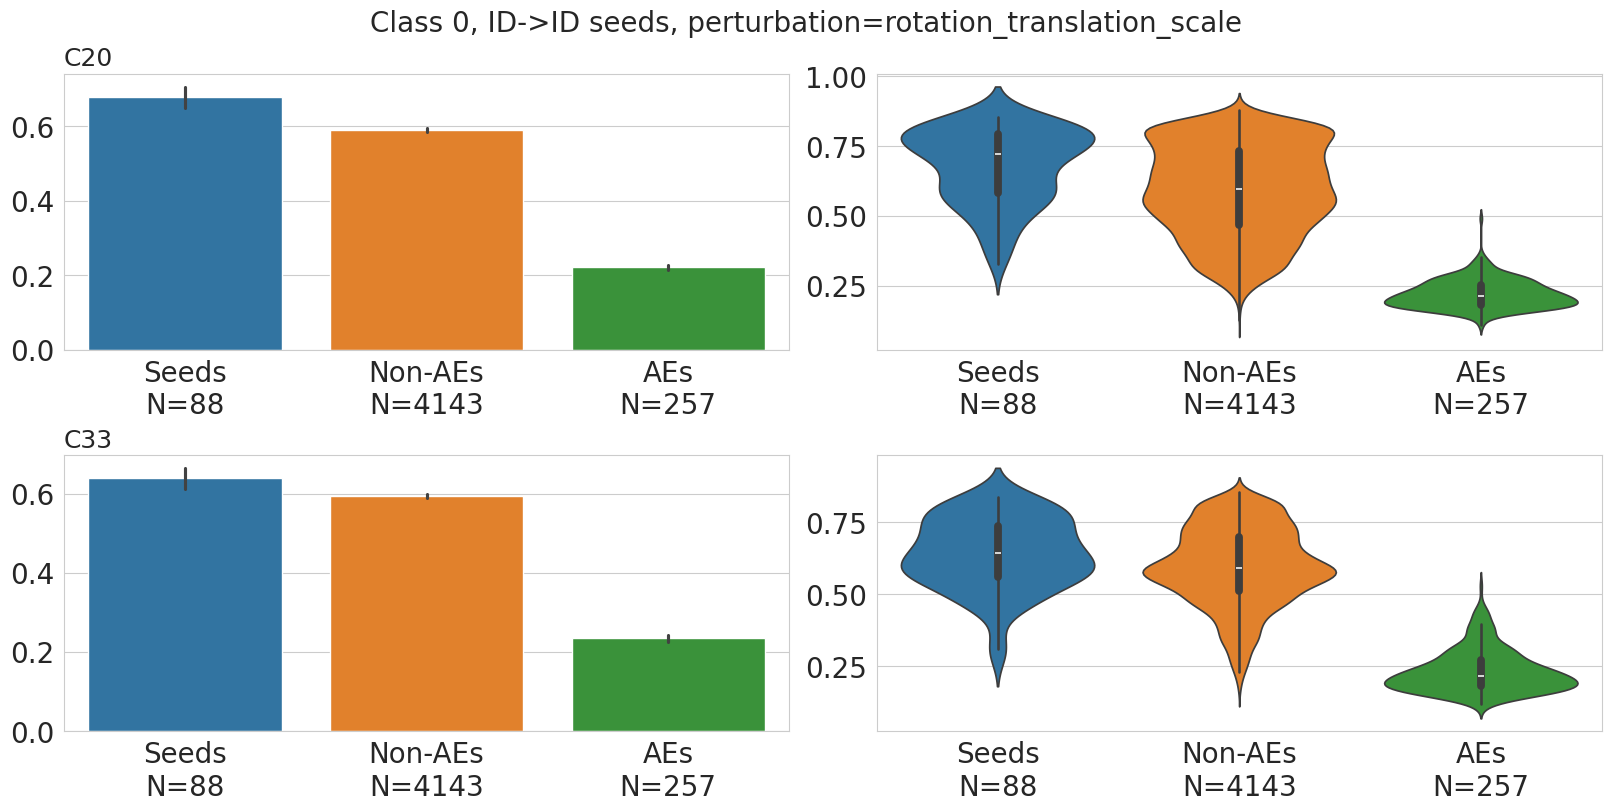

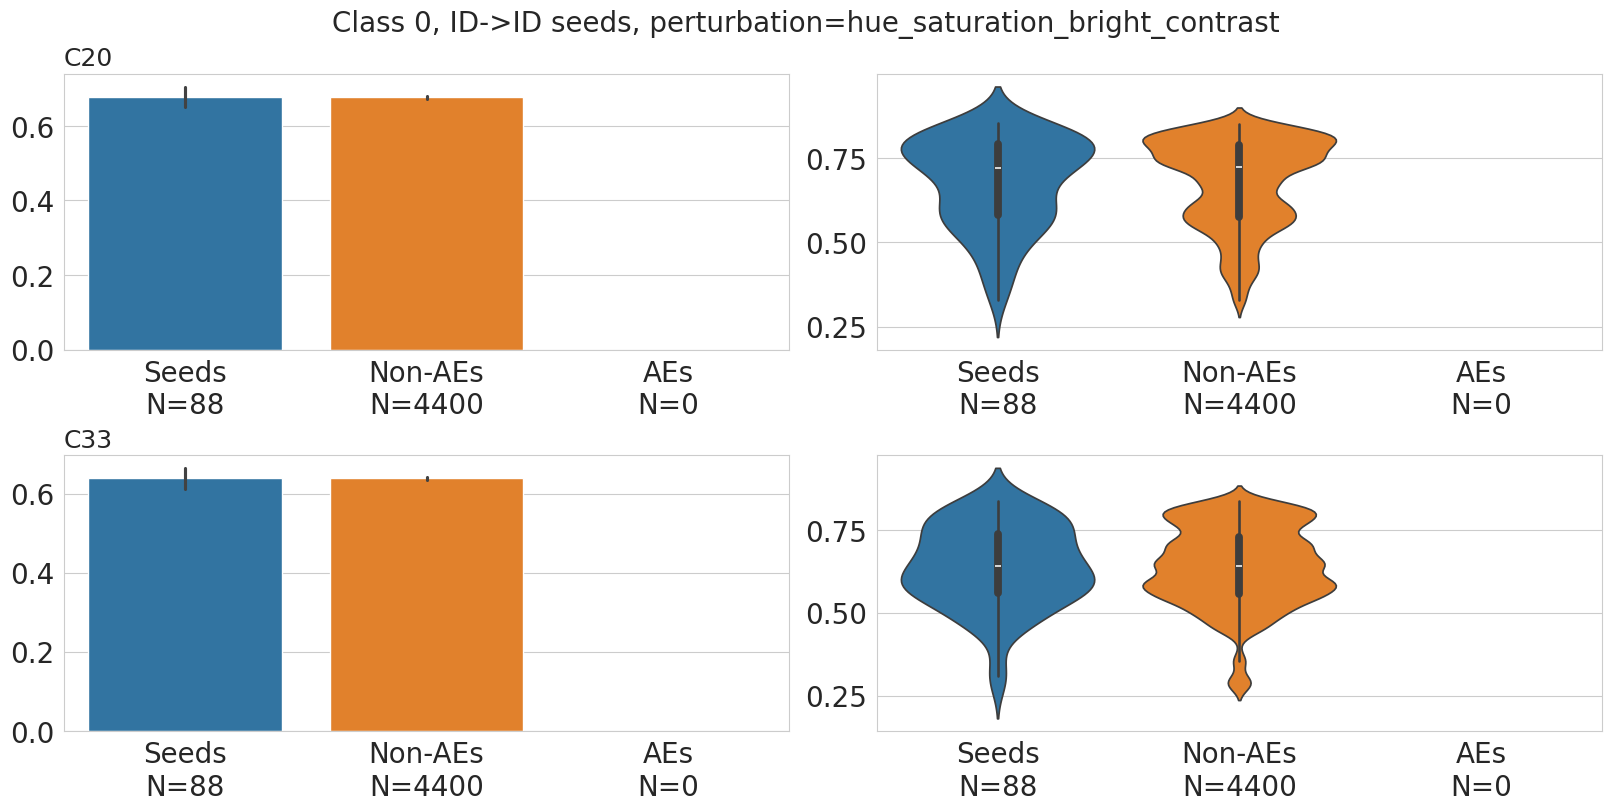

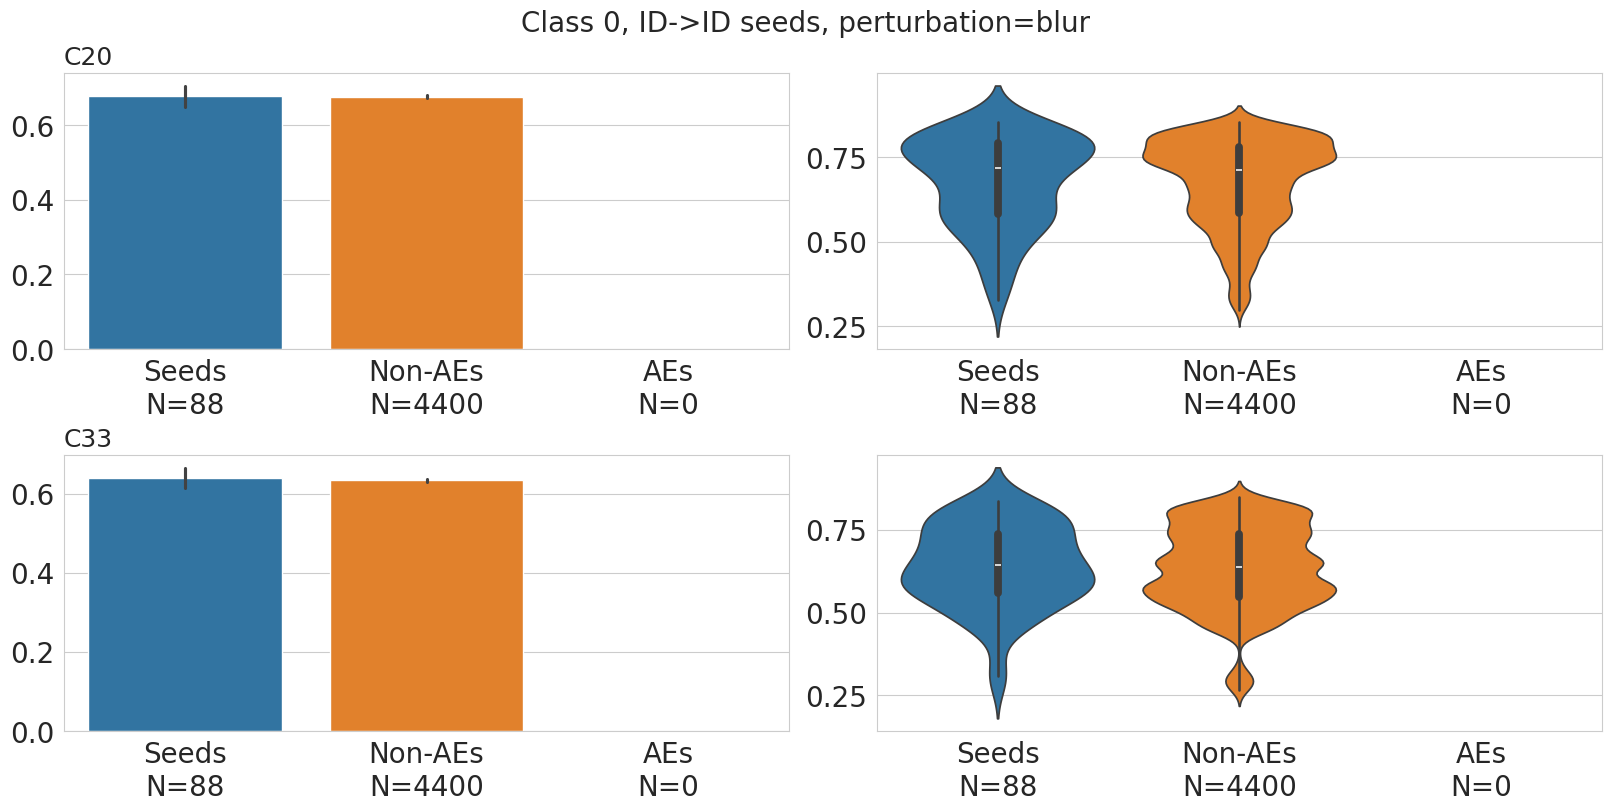

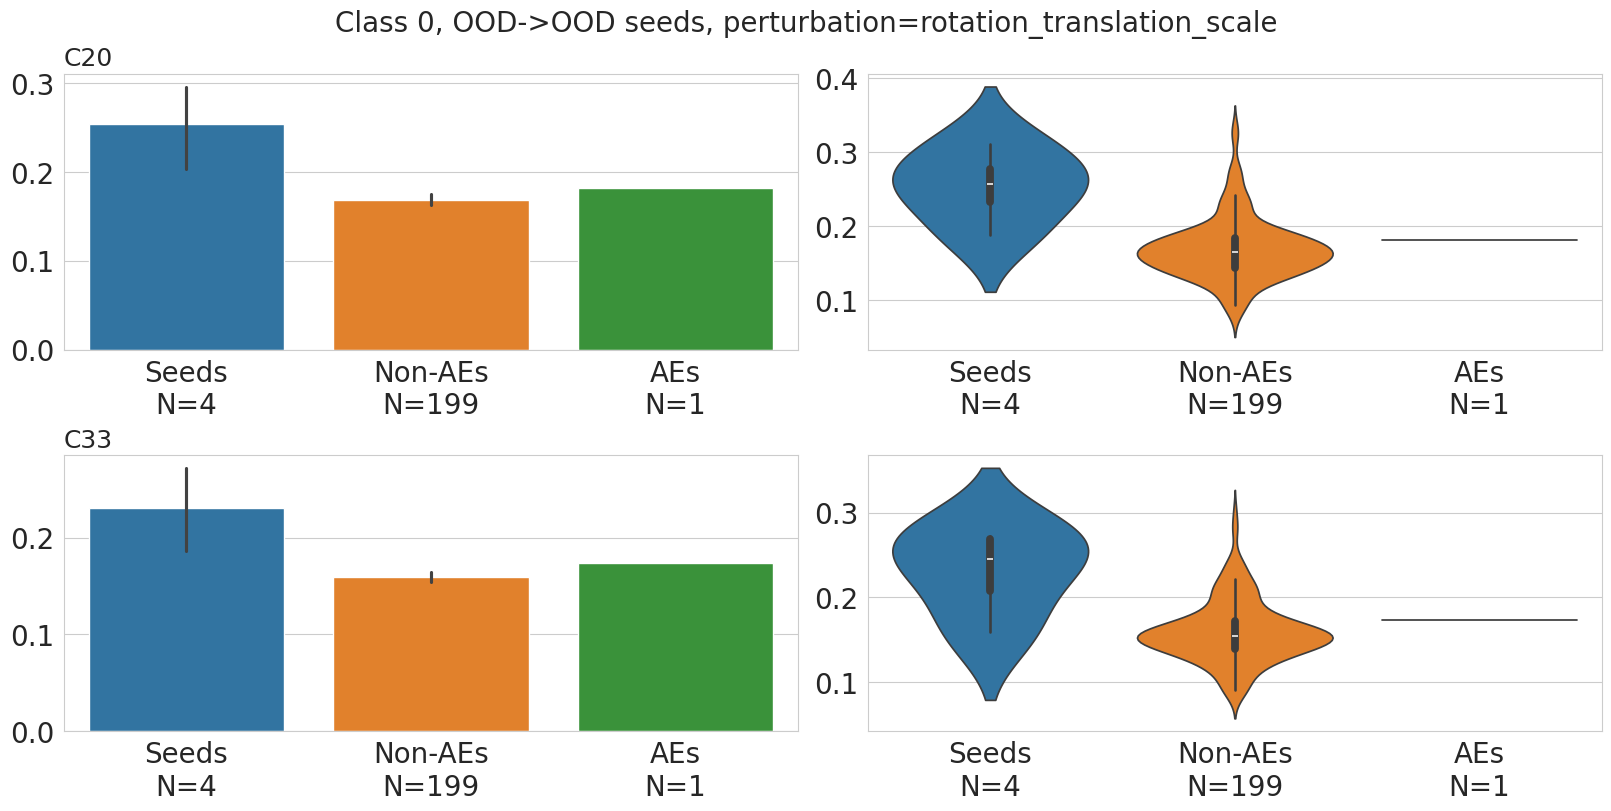

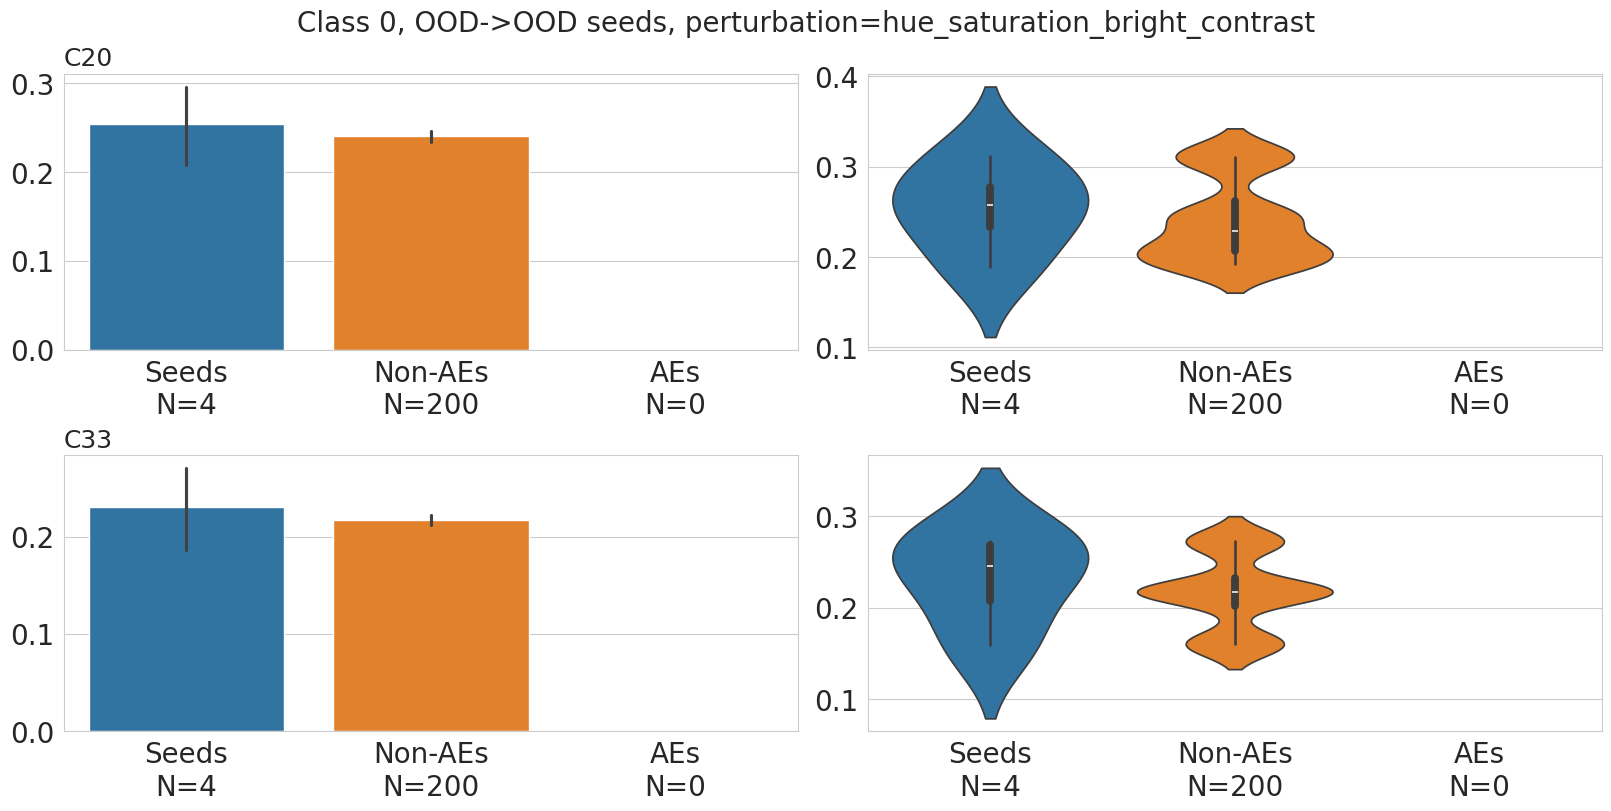

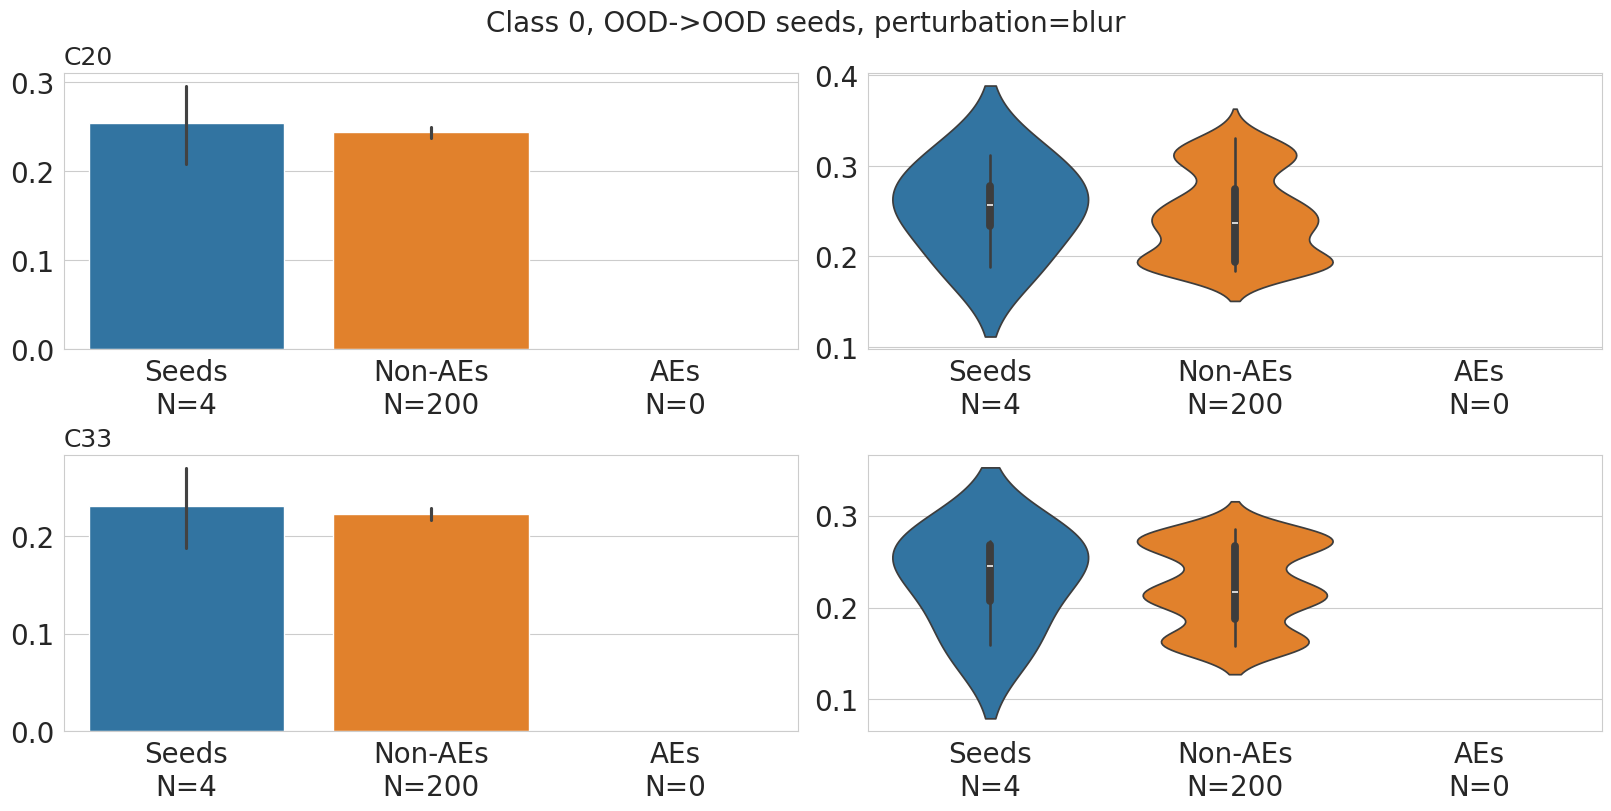

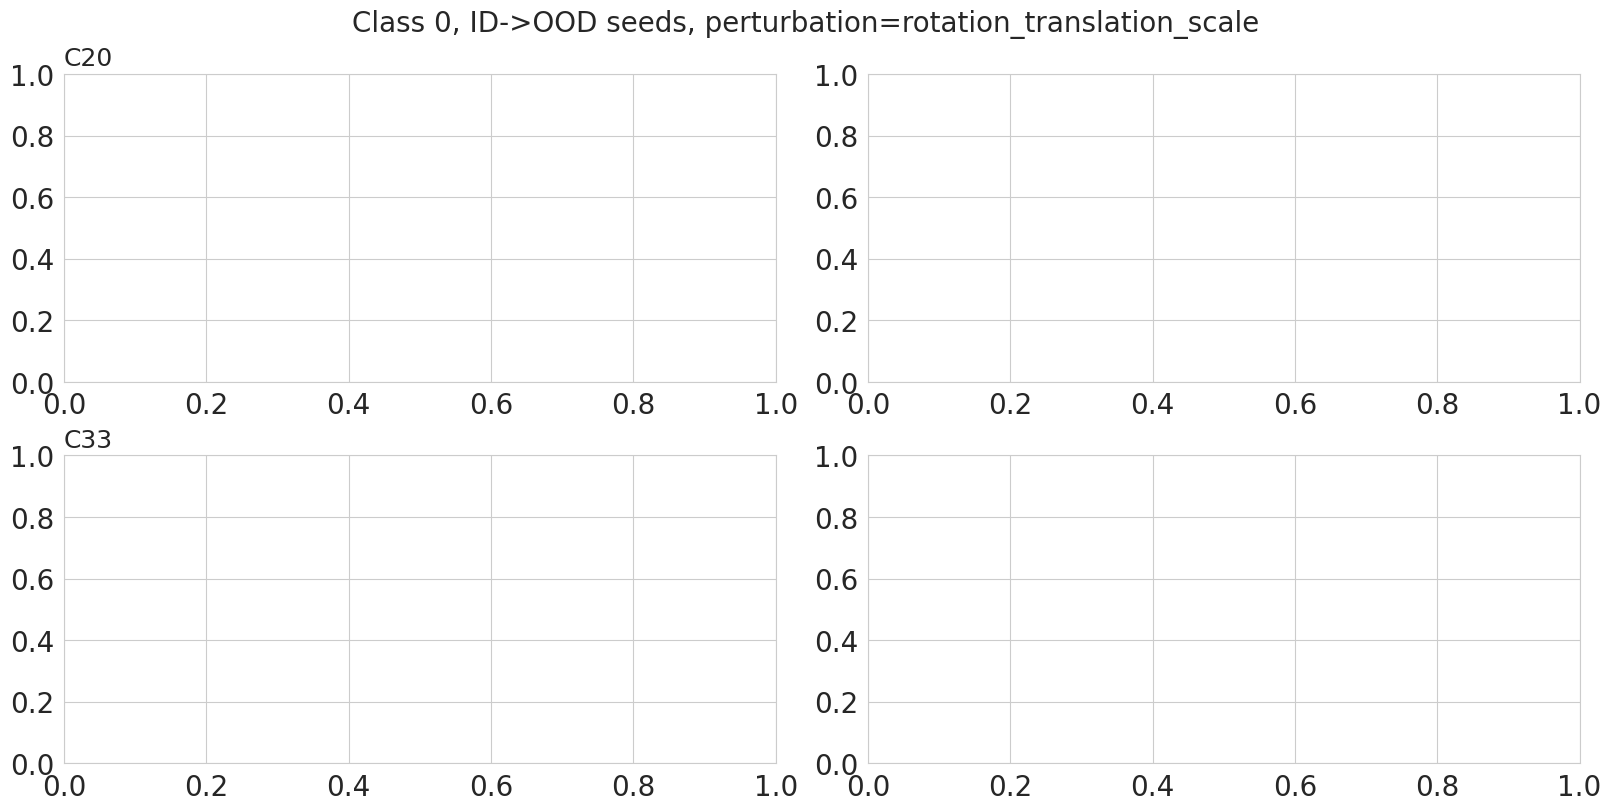

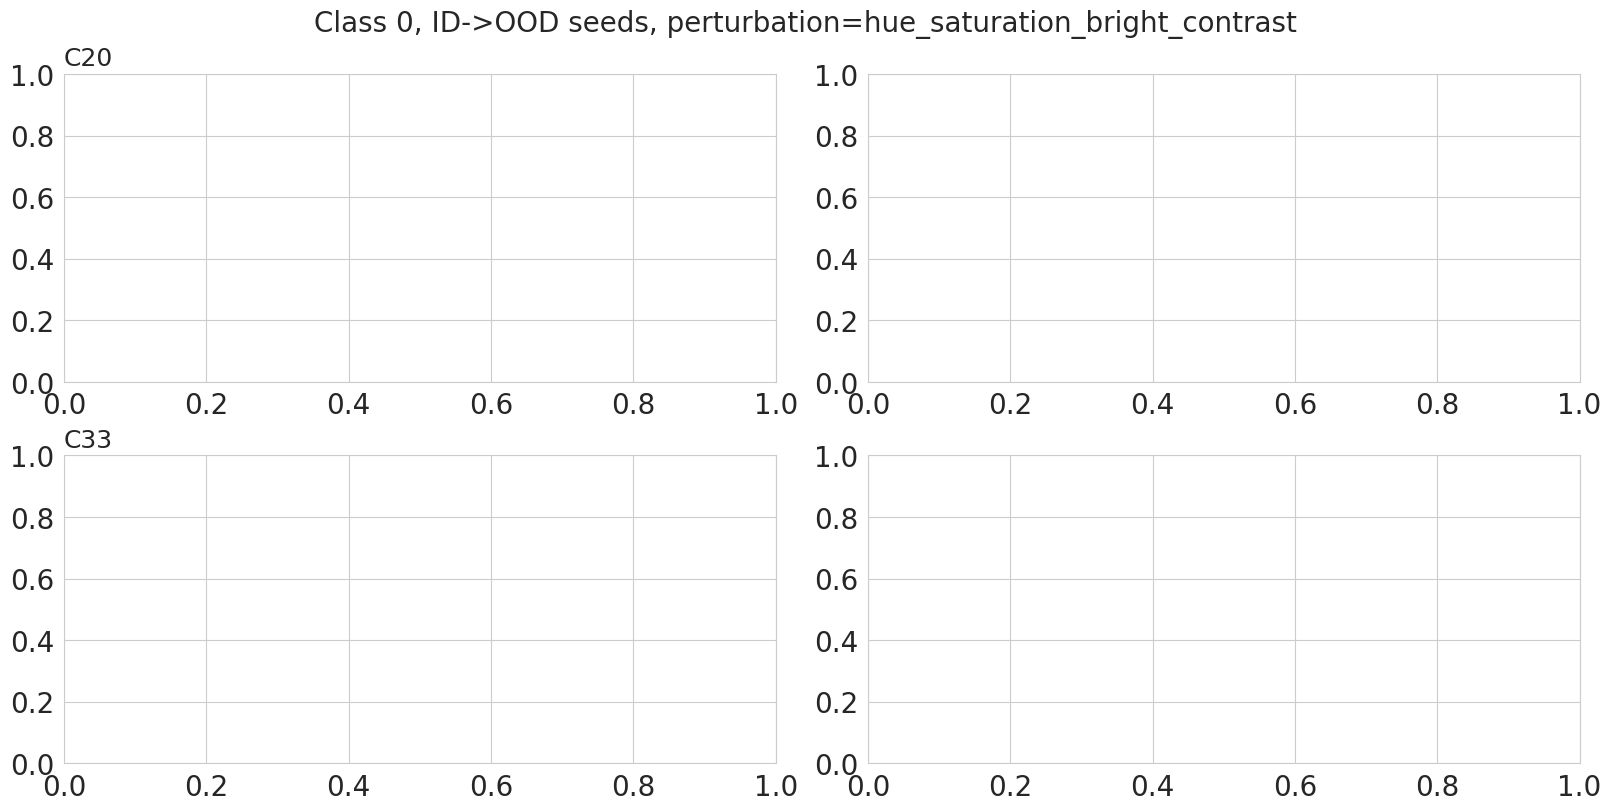

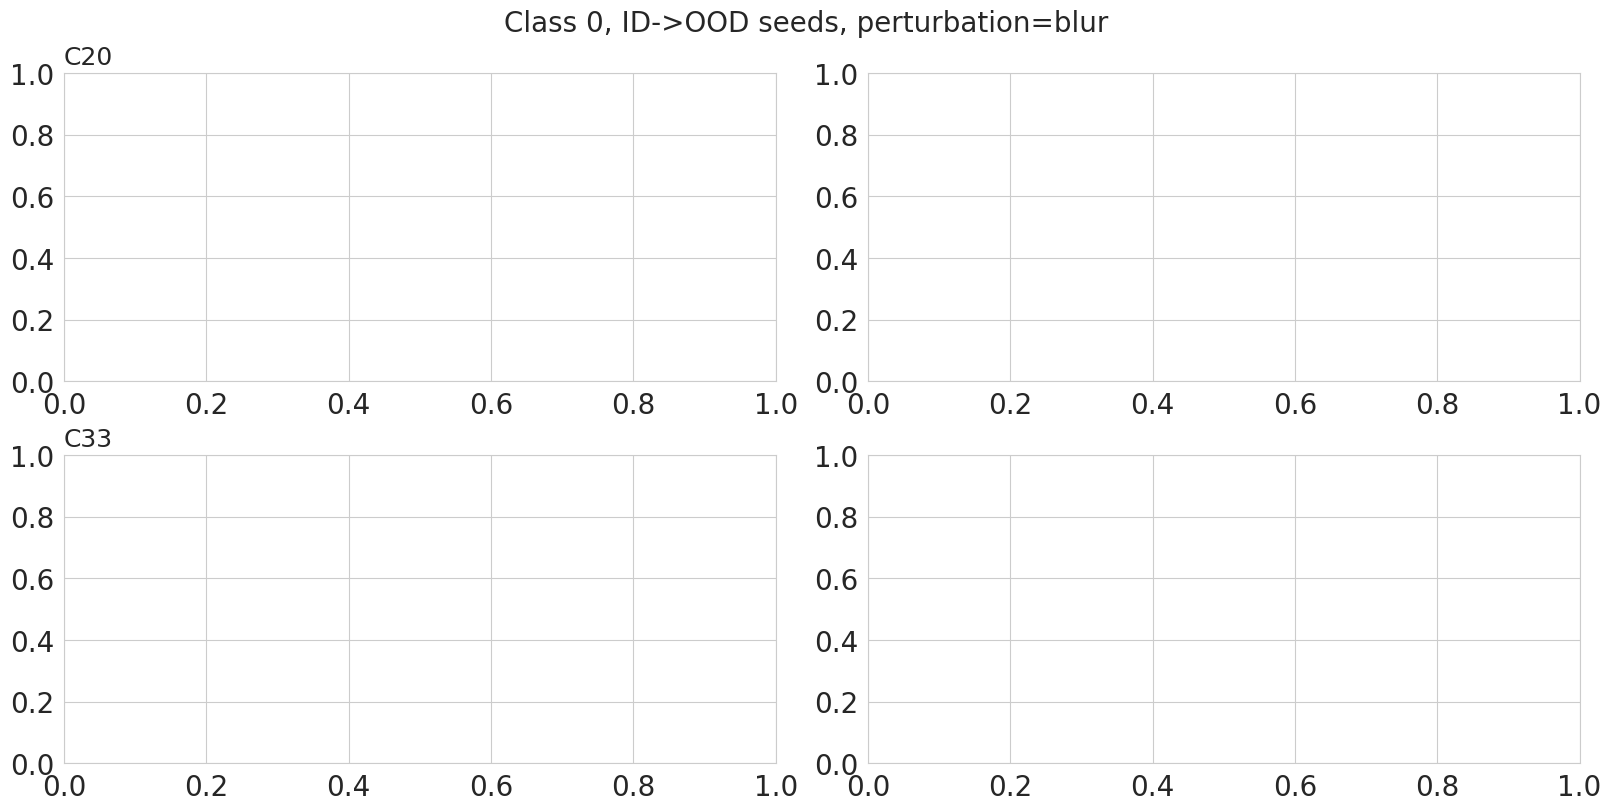

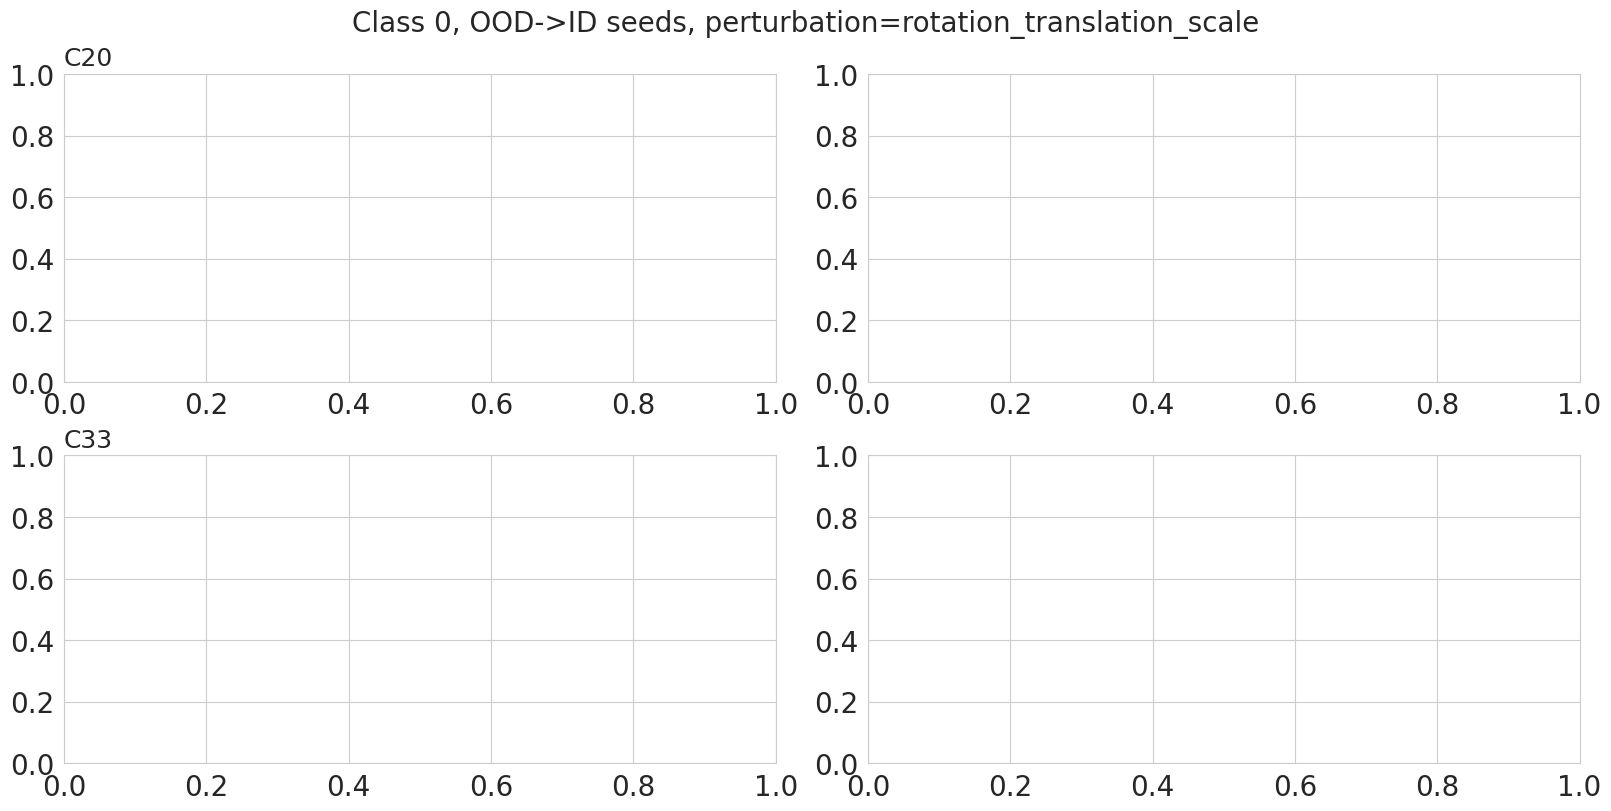

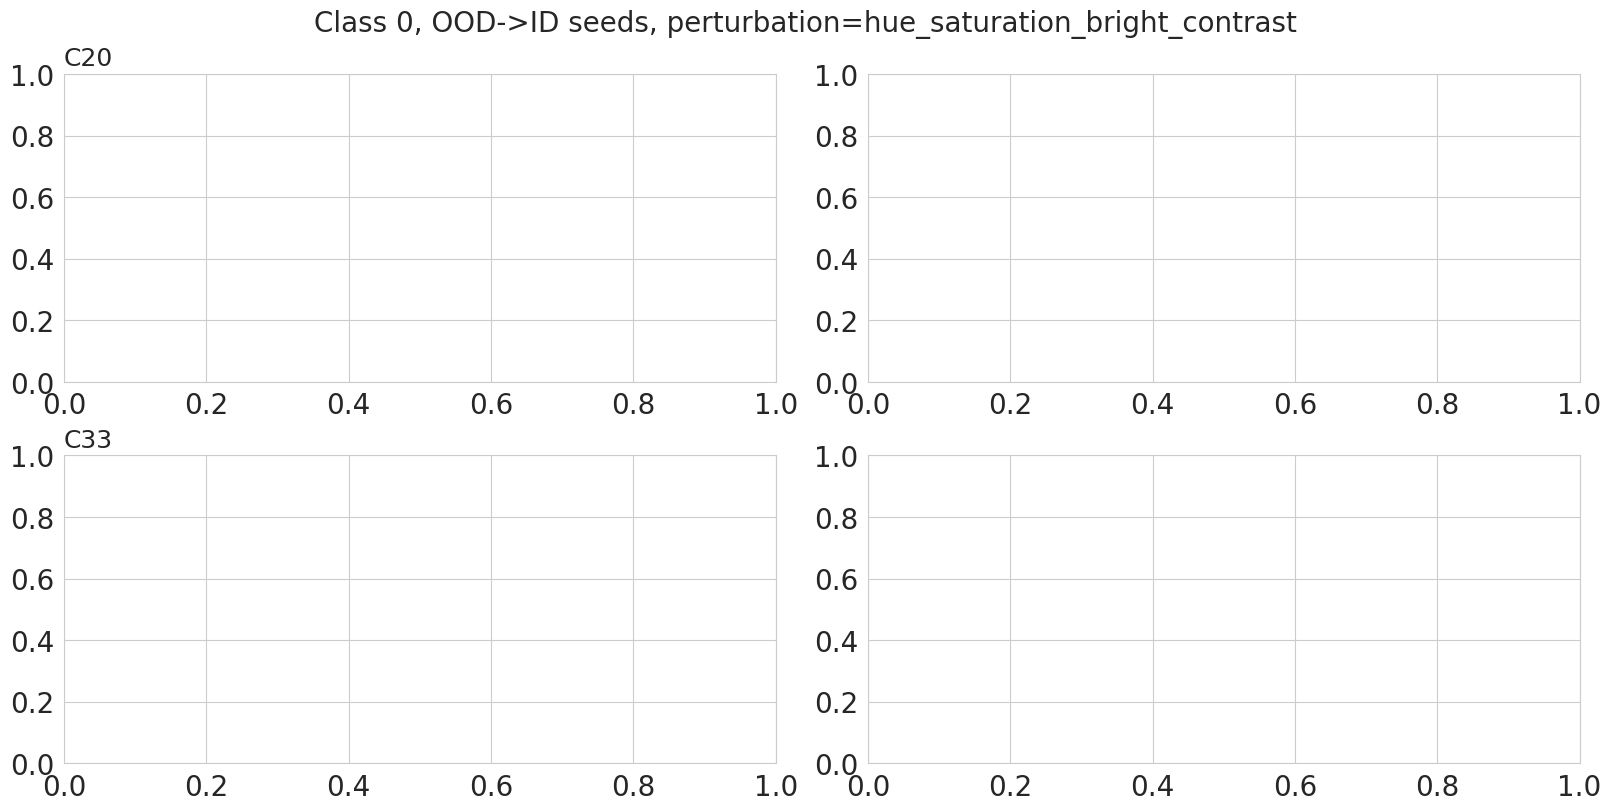

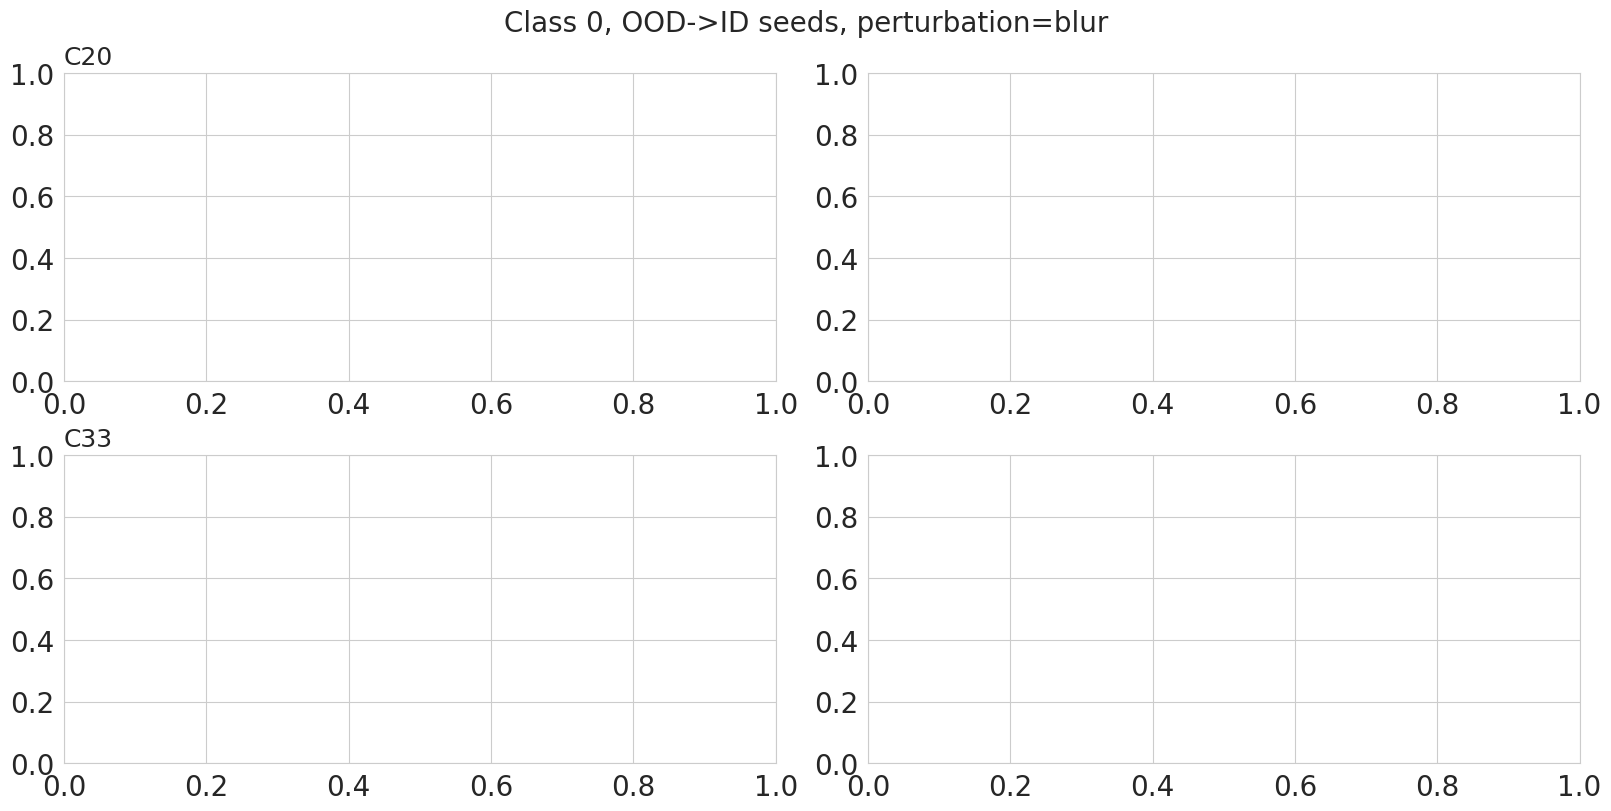

Concepts of class 12: [12]


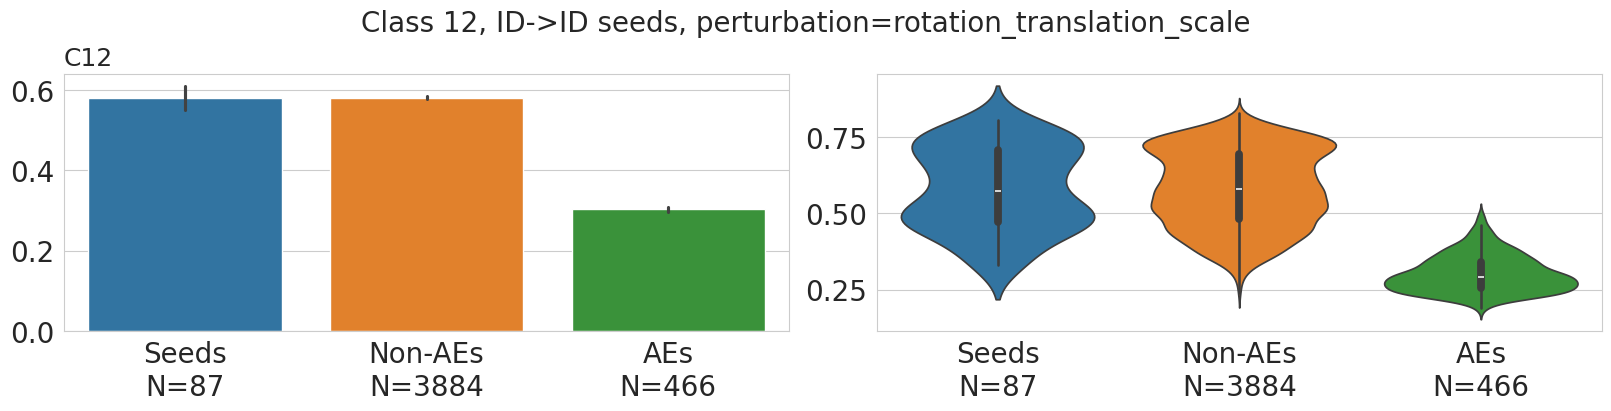

In [ ]:
def gaussian_blur(img, kernel_size=11, sigma=5):
    def gauss_kernel(channels, kernel_size, sigma):
        ax = tf.range(-kernel_size // 2 + 1.0, kernel_size // 2 + 1.0)
        xx, yy = tf.meshgrid(ax, ax)
        kernel = tf.exp(-(xx ** 2 + yy ** 2) / (2.0 * sigma ** 2))
        kernel = kernel / tf.reduce_sum(kernel)
        kernel = tf.tile(kernel[..., tf.newaxis], [1, 1, channels])
        return kernel

    gaussian_kernel = gauss_kernel(tf.shape(img)[-1], kernel_size, sigma)
    gaussian_kernel = gaussian_kernel[..., tf.newaxis]

    return tf.nn.depthwise_conv2d(np.expand_dims(img, axis=0), gaussian_kernel, [1, 1, 1, 1],
                                  padding='SAME', data_format='NHWC')
    
k = 10
# perturbations = [
#                 "rotation", "translation", "scale",
#                 # "hue", "saturation", "bright_contrast",
#                 # "blur",
#                 # "Linf"
#                 ]
n_seeds = 100
n_sampling = 50
os.makedirs(os.path.join(args.result_dir, "concept_sims"), exist_ok=True)
            
with tf.device('/CPU:0'):
    for class_i in [0, 12, 25, 5, 40]: # , 12, 25, 5, 40
        concepts = []
        concepts_maxpatch = np.argsort(in_test_concepts, axis=0)[::-1]
        for concept_id in range(N_CONCEPTS):
            if (y_test[concepts_maxpatch[:4, concept_id]] == class_i).all():
                concepts.append(concept_id)
        concepts = np.array(concepts, dtype=int)
        print(f"Concepts of class {class_i}:", concepts)
        
        idx_in_true = np.where((in_test_yhat == class_i)*(y_test==class_i))[0]
        idx_in_false = np.where((in_test_yhat == class_i)*(y_test!=class_i))[0]
        
        idx_IN_IN = np.where((in_test_yhat == class_i)*(y_test==class_i)*(in_test_scores>=thres95))[0]   # ID detected as ID
        idx_IN_OUT = np.where((in_test_yhat == class_i)*(y_test==class_i)*(in_test_scores<thres95))[0]   # ID detected as OOD
        idx_OUT_OUT = np.where((out_test_yhat == class_i)*(out_test_scores<thres95))[0] # OOD detected as OOD
        idx_OUT_IN = np.where((out_test_yhat == class_i)*(out_test_scores>=thres95))[0]   # OOD detected as ID
        
        sp_groups = {"ID->ID": idx_IN_IN, "OOD->OOD": idx_OUT_OUT, "ID->OOD": idx_IN_OUT, "OOD->ID": idx_OUT_IN, }
        for grp_name, grp in sp_groups.items():
            if len(grp) > n_seeds:
                idx_ = np.random.choice(grp, size=n_seeds,replace=False)
            else:
                idx_ = grp
            if ("ID->" in grp_name) or ("ID_" in grp_name):
                x_seeds = np.array([in_loader[i_//256][0][i_%256] for i_ in idx_])
                c_seeds = in_test_concepts[idx_, :]
            else:
                x_seeds = np.array([out_loader[i_//256][i_%256] for i_ in idx_])
                c_seeds = out_test_concepts[idx_, :]

            for perturbations in [
                                  ["rotation", "translation", "scale"],
                                  ["hue", "saturation", "bright_contrast"],
                                  ["blur"]
                                ]: 
                # "rotation", "translation", "scale"
            
                c_perbs_all = np.empty((0, N_CONCEPTS))
                s_perbs_all = np.empty(0)
                
                for x_seed in x_seeds:
                    
                    # +perturbations
                    x_seed = np.expand_dims(x_seed, axis=0)
                    x_perbs = np.repeat(x_seed, n_sampling, axis=0)
                    
                    if "rotation" in perturbations:
                        rot = tf.keras.layers.RandomRotation(factor=(-0.1, 0.1), fill_mode="constant")
                        x_perbs = rot(x_perbs)
                    elif "translation" in perturbations:
                        trans = tf.keras.layers.RandomTranslation(height_factor=(-0.2, 0.2), width_factor=(-0.2, 0.2), 
                                                                  fill_mode="constant")
                        x_perbs = trans(x_perbs)
                    elif "scale" in perturbations:
                        scale = tf.keras.layers.RandomZoom(height_factor=(-0.2, 0.2), fill_mode="constant")
                        x_perbs = scale(x_perbs)
                    elif "hue" in perturbations:
                        x_perbs = tf.image.random_hue(x_perbs, 0.15, seed=None)
                    elif "bright_contrast" in perturbations:
                        x_perbs = tf.image.random_brightness(x_perbs, 0.3, seed=None)
                        x_perbs = tf.image.random_contrast(x_perbs, 0.7, 1.3)
                    elif "saturation" in perturbations:
                        saturation_factor = np.random.uniform(0.5, 1.5)
                        x_perbs = tf.image.adjust_saturation(x_perbs, saturation_factor)
                    elif "blur" in perturbations:
                        sigmas = np.random.uniform(0.2, 0.8, size=x_perbs.shape[0])
                        for i_, sig in enumerate(sigmas):
                            x_perbs[i_] = gaussian_blur(x_perbs[i_], kernel_size=10, sigma=sig)
                    elif "Linf" in perturbations:
                        x_perbs += np.random.uniform(0, 0.1, size=x_perbs.shape)
              
                    f_perbs = feature_model(x_perbs)
                    c_perbs, logit_perbs = compute_concept_scores(topic_vec, f_perbs, predict_model)
                    y_pred_perbs = np.argmax(logit_perbs)
    
                    s_perbs = run_ood_over_batch(x_perbs, feature_model, predict_model, args, N_CLASSES).numpy()
    
                    c_perbs_all = np.concatenate([c_perbs_all, c_perbs])
                    s_perbs_all = np.concatenate([s_perbs_all, s_perbs])
    
                if ("ID->" in grp_name) or ("ID_" in grp_name):
                    i_naes = np.where(s_perbs_all >= thres95)[0]
                    i_aes = np.where(s_perbs_all < thres95)[0]
                else:
                    i_naes = np.where(s_perbs_all < thres95)[0]
                    i_aes = np.where(s_perbs_all >= thres95)[0]
    
                c_naes = c_perbs_all[i_naes]
                c_aes = c_perbs_all[i_aes]
    
                fig, axes = plt.subplots(len(concepts),2, figsize=(16, len(concepts)*4), layout="constrained")
                axes = axes.flatten()
                for a_i in range(0, len(axes), 2):
                    c_i = concepts[a_i//2]
                    ax = axes[a_i]
                    ax1 = axes[a_i+1]
                    sns.barplot({f"Seeds\nN={len(idx_)}": c_seeds[:, c_i], 
                                f"Non-AEs\nN={len(i_naes)}": c_naes[:, c_i], 
                                f"AEs\nN={len(i_aes)}": c_aes[:, c_i]}, ax=ax)
                    sns.violinplot({f"Seeds\nN={len(idx_)}": c_seeds[:, c_i], 
                                f"Non-AEs\nN={len(i_naes)}": c_naes[:, c_i], 
                                f"AEs\nN={len(i_aes)}": c_aes[:, c_i]}, ax=ax1)
                    ax.set_title(f"C{c_i}", fontsize=18, loc="left")
                plt.suptitle(f"Class {class_i}, {grp_name} seeds, perturbation={'_'.join(perturbations)}")
                os.makedirs(os.path.join(args.result_dir, "robustness_test"), exist_ok=True)
                plt.savefig(os.path.join(args.result_dir, "robustness_test", f"class_{class_i}_{grp_name}_perb_{'_'.join(perturbations)}.jpg"))
                plt.show()
                plt.close("all")